In [ ]:
from google.colab import drive
drive.mount('/googledrive', force_remount=True)


In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau, CSVLogger 
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os


%matplotlib inline
import matplotlib.pyplot as plt

# !pip install livelossplot 
from livelossplot import PlotLossesKeras


from keras import backend

from keras.layers import AveragePooling1D, Input, GlobalMaxPooling1D
from keras import layers, models
from keras import backend

        
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)

Using TensorFlow backend.


# Data

## Load Data set 

(12000, 500) (12000,)


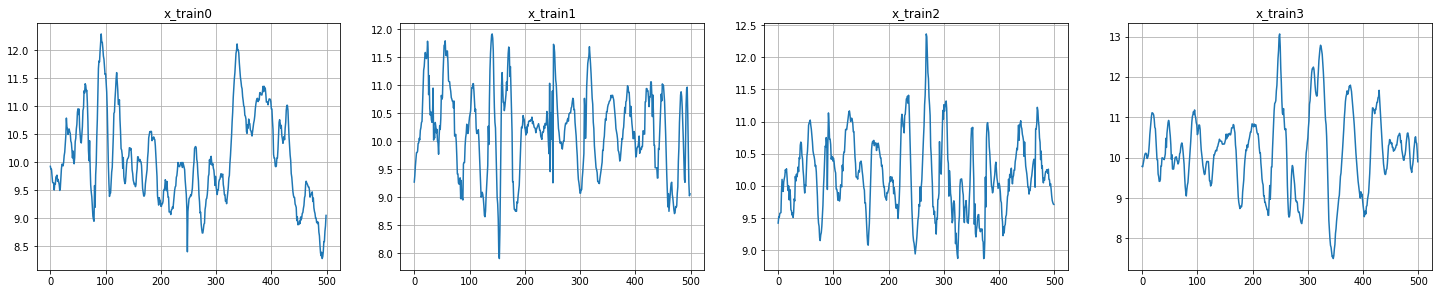

In [100]:
# # data_set_path = './data_set/my_data/class_9'
# data_set_path = './data_set/nonsvm/'

# save_path = './save_file/data_3_100_my_svm'

# x_data = np.load(data_set_path+"/x_data_3_100_my_nonsvm.npy")
# y_data = np.load(data_set_path+"/y_data_3_100_my_nonsvm.npy")
# print(x_data.shape, y_data.shape)

# data_classes = 3


# data_set_path = './data_set/my_data/class_9'
data_set_path = './data_set/svm'

# save_path = './save_file/data_3_100_my_svm'
save_path = './save_file/data_6_500_hard_svm_acc'


x_data = np.load(data_set_path+"/x_data_6_500_hard_svm_acc.npy")
y_data = np.load(data_set_path+"/y_data_6_500_hard_svm_acc.npy")
print(x_data.shape, y_data.shape)

data_classes = 6


# # Normalization
# for idx in range(len(x_data)):
#     min = np.min(x_data[idx])
#     max = np.max(x_data[idx])
#     x_data[idx] = (x_data[idx] - min) / (max - min)

# fig = plt.figure(figsize=(25,10))

# for id in range(4):
#     ax = fig.add_subplot(2,4,id+1)
#     ax.plot(x_data[id])
#     ax.grid(True)
#     ax.set_title(f"x_train{id}")

# # Standardize
# for idx in range(len(x_data)):
#     standard_deviation = np.std(x_data[idx])
#     mean = np.mean(x_data[idx])
#     x_data[idx] = (x_data[idx] - mean) / standard_deviation


# fig = plt.figure(figsize=(25,10))

# for id in range(4):
#     ax = fig.add_subplot(2,4,id+1)
#     ax.plot(x_data[id])
#     ax.grid(True)
#     ax.set_title(f"x_train{id}")

fig = plt.figure(figsize=(25,10))

for id in range(4):
    ax = fig.add_subplot(2,4,id+1)
    ax.plot(x_data[id])
    ax.grid(True)
    ax.set_title(f"x_train{id}")



## Data Augmentation

In [ ]:

class TimeSeriesDataAugmentation:

    # def __init__(self):
        # self.sigma = 0.05

    def DA_Jitter(self, X, sigma=0.05):
        myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
        return X+myNoise

    def DA_Scaling(self, X, sigma=0.1):
        scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1)) # shape=(1,3)
        myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
        return X*myNoise


    def GenerateRandomCurves(self, X, sigma=0.2, knot=4):
        
        xx = np.arange(0, X.shape[0], (X.shape[0]-1) / (knot + 1)) #(3,1) * (1, 6) = (3,6) // (6,3)

        yy = np.random.normal(loc = 1.0, scale = sigma, size = (knot + 2)) # (6, 3)
        x_range = np.arange(X.shape[0])

        cs_x = CubicSpline(xx, yy)

        return np.array(cs_x(x_range))


    def DA_MagWarp(self, X, sigma=0.2):
        return X * self.GenerateRandomCurves(X, sigma)



    def DistortTimesteps(self, X, sigma=0.2, knot=4):
        tt = self.GenerateRandomCurves(X, sigma, knot) # Regard these samples aroun 1 as time intervals
        tt_cum = np.cumsum(tt)        # Add intervals to make a cumulative graph
        t_scale = (X.shape[0]-1) / tt_cum[-1] 

        tt_cum = tt_cum * t_scale

        return tt_cum



    def DA_TimeWarp(self, X, sigma=0.2):
        tt_new = self.DistortTimesteps(X, sigma)

        X_new = np.zeros(X.shape) #(3600, 3)      0

        x_range = np.arange(X.shape[0]) #(3600,)  0~3599

        X_new = np.interp(x_range, tt_new, X)

        return X_new



    def DA_Permutation(self, X, nPerm=4, minSegLength=10):
        data = X
        X_new = np.zeros(data.shape)     #(100,)
        idx = np.random.permutation(nPerm) 

        bWhile = True
        while bWhile == True:
            segs = np.zeros(nPerm+1, dtype=int)
            
            segs[1:-1] = np.sort(np.random.randint(minSegLength, data.shape[0]-minSegLength, nPerm-1))
            segs[-1] = data.shape[0]

            if np.min(segs[1:] - segs[0:-1]) > minSegLength:
                bWhile = False

        pp = 0
        for ii in range(nPerm):
            x_temp = data[segs[idx[ii]]:segs[idx[ii]+1]]
            X_new[pp:pp+len(x_temp)] = x_temp
            pp += len(x_temp)

        return X_new




    def DA_Permutation(self, X, nPerm=4, minSegLength=10):
        data = X
        X_new = np.zeros(data.shape)     #(100,)
        idx = np.random.permutation(nPerm) 

        bWhile = True
        while bWhile == True:
            segs = np.zeros(nPerm+1, dtype=int)
            
            segs[1:-1] = np.sort(np.random.randint(minSegLength, data.shape[0]-minSegLength, nPerm-1))
            segs[-1] = data.shape[0]

            if np.min(segs[1:] - segs[0:-1]) > minSegLength:
                bWhile = False

        pp = 0
        for ii in range(nPerm):
            x_temp = data[segs[idx[ii]]:segs[idx[ii]+1]]
            X_new[pp:pp+len(x_temp)] = x_temp
            pp += len(x_temp)

        return X_new

    

## Data split

In [ ]:

#data_set_구분
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1, shuffle=False)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

#y_data onehot encoding
y_train = keras.utils.to_categorical(y_train, data_classes)
y_test = keras.utils.to_categorical(y_test, data_classes)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

## Data packaging

In [ ]:
isPerdata = True
# isPerdata = False

if not isPerdata:
    x_train = x_train.reshape(-1, 100)
    x_test  = x_test.reshape(-1, 100)
    y_train = y_train.reshape(-1, 9)
    y_test = y_test.reshape(-1, 9)
else:
    # x_train = x_train.reshape(-1, 1, 100)
    # x_test  = x_test.reshape(-1, 1, 100)
#     y_train = y_train.reshape(-1, 1, 9)
#     y_test = y_test.reshape(-1, 1, 9)
    x_train = x_train.reshape(-1, 100,1)
    x_test  = x_test.reshape(-1, 100,1)
    # y_train = y_train.reshape(-1, 9)
    # y_test = y_test.reshape(-1, 9)


# x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
# x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# k fold cross validation

In [101]:
#y_data onehot encoding
y = keras.utils.to_categorical(y_data, data_classes)
x = x_data.reshape(-1, 500,1)

print(x.shape, y.shape)

(12000, 500, 1) (12000, 6)


In [17]:

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


from keras import backend as K

# 특정 클래스에 대한 정밀도
def single_class_precision(interesting_class_id):
    def prec(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        precision_mask = K.cast(K.equal(class_id_pred, interesting_class_id), 'int32')
        class_prec_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * precision_mask
        class_prec = K.cast(K.sum(class_prec_tensor), 'float32') / K.cast(K.maximum(K.sum(precision_mask), 1), 'float32')
        return class_prec
    return prec


# 특정 클래스에 대한 재현율
def single_class_recall(interesting_class_id):
    def recall(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        recall_mask = K.cast(K.equal(class_id_true, interesting_class_id), 'int32')
        class_recall_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * recall_mask
        class_recall = K.cast(K.sum(class_recall_tensor), 'float32') / K.cast(K.maximum(K.sum(recall_mask), 1), 'float32')
        return class_recall
    return recall



In [80]:
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score


# Model

In [88]:
def createCNNModel(depth=None,
            growthRate = None,
            input_shape = None,            
            pooling = None,
            classes = None):
    
    nChannels = 2 * growthRate
    bn_axis = 2

    img_input = layers.Input(shape=input_shape)

    x = layers.ZeroPadding1D(padding=3)(img_input)
    x = layers.Conv1D(nChannels, 7, strides=1, use_bias=True, name='conv1/conv')(x)
    
    
    for i in range(depth):
        x = layers.Conv1D(4 * growthRate, 1, use_bias=True, kernel_initializer='he_normal', name=f'{i+1}_conv')(x)
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=f'{i+1}_bn')(x)
        x = layers.Activation('relu', name=f'{i+1}_relu')(x)
    

    x = layers.GlobalAveragePooling1D(name='avg_pool')(x)
    x = layers.Dense(classes, activation='softmax', name='fc')(x)

    model = models.Model(img_input, x, name=f"{depth}_model")

    return model




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 100, 1)            0         
_________________________________________________________________
zero_padding1d_1 (ZeroPaddin (None, 106, 1)            0         
_________________________________________________________________
conv1/conv (Conv1D)          (None, 100, 24)           192       
_________________________________________________________________
1_conv (Conv1D)              (None, 100, 48)           1200      
_________________________________________________________________
1_bn (BatchNormalization)    (None, 100, 48)           192       
_________________________________________________________________
1_relu (Activation)          (None, 100, 48)           0         
_________________________________________________________________
2_conv (Conv1D)              (None, 100, 48)           2352      
__________

In [98]:
from keras.regularizers import l2



def createVGGModel(input_shape = None,            
            n_classes = None, l2_regularization=0.0005):
    l2_reg = l2_regularization # Make the internal name shorter.

    n_boxes = [10,10,10,10,6,6]
    bn_axis=-1
    
    img_input = layers.Input(shape=input_shape)

    conv1_1 = layers.Conv1D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv1_1')(img_input)
#     conv1_1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1_1_bn')(conv1_1)
#     conv1_1 = layers.Activation('relu', name='conv1_1_relu')(conv1_1)
    conv1_2 = layers.Conv1D(32, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv1_2')(conv1_1)
#     conv1_2 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1_2_bn')(conv1_2)
#     conv1_2 = layers.Activation('relu', name='conv1_2_relu')(conv1_2)
    pool1 = layers.MaxPooling1D(pool_size=2, strides=2, padding='same', name='pool1')(conv1_2)

    conv2_1 = layers.Conv1D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv2_1')(pool1)
#     conv2_1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv2_1_bn')(conv2_1)
#     conv2_1 = layers.Activation('relu', name='conv2_1_relu')(conv2_1)
    conv2_2 = layers.Conv1D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv2_2')(conv2_1)
#     conv2_2 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv2_2_bn')(conv2_2)
#     conv2_2 = layers.Activation('relu', name='conv2_2_relu')(conv2_2)
    pool2 = layers.MaxPooling1D(pool_size=2, strides=2, padding='same', name='pool2')(conv2_2)

    conv3_1 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv3_1')(pool2)
#     conv3_1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv3_1_bn')(conv3_1)
#     conv3_1 = layers.Activation('relu', name='conv3_1relu')(conv3_1)
    conv3_2 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv3_2')(conv3_1)
#     conv3_2 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv3_2_bn')(conv3_2)
#     conv3_2 = layers.Activation('relu', name='conv3_2_relu')(conv3_2)
    conv3_3 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv3_3')(conv3_2)
#     conv3_3 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv3_3_bn')(conv3_3)
#     conv3_3 = layers.Activation('relu', name='conv3_3_relu')(conv3_3)
    pool3 = layers.MaxPooling1D(pool_size=2, strides=2, padding='same', name='pool3')(conv3_3)

    conv4_1 = layers.Conv1D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_1')(pool3)
    conv4_2 = layers.Conv1D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_2')(conv4_1)
    conv4_3 = layers.Conv1D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_3')(conv4_2)
    pool4 = layers.MaxPooling1D(pool_size=2, strides=2, padding='same', name='pool4')(conv4_3)

    conv5_1 = layers.Conv1D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv5_1')(pool4)
    conv5_2 = layers.Conv1D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv5_2')(conv5_1)
    conv5_3 = layers.Conv1D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv5_3')(conv5_2)
    pool5 = layers.MaxPooling1D(pool_size=3, strides=1, padding='same', name='pool5')(conv5_3)

    fc6 = layers.Conv1D(1024, 3, dilation_rate=6, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc6')(pool5)

    fc7 = layers.Conv1D(1024, 1, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7')(fc6)

    conv6_1 = layers.Conv1D(128, 1, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_1')(fc7)
    conv6_1 = layers.MaxPooling1D( padding='same', name='conv6_padding')(conv6_1)
    conv6_2 = layers.Conv1D(256, 3, strides=2, activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_2')(conv6_1)

#     conv7_1 = layers.Conv1D(128, 1, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_1')(conv6_2)
#     conv7_1 = layers.MaxPooling1D( padding='same', name='conv7_padding')(conv7_1)
#     conv7_2 = layers.Conv1D(256, 3, strides=2, activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_2')(conv7_1)

#     conv8_1 = layers.Conv1D(128, 1, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_1')(conv7_2)
#     conv8_2 = layers.Conv1D(256, 3, strides=1, activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_2')(conv8_1)

#     conv9_1 = layers.Conv1D(128, 1, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_1')(conv8_2)
#     conv9_2 = layers.Conv1D(256, 3, strides=1, activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_2')(conv9_1)

    
#     conv4_3_norm = keras.backend.l2_normalize(name='conv4_3_norm')(conv4_3)

    ### Build the convolutional predictor layers on top of the base network

    # We precidt `n_classes` confidence values for each box, hence the confidence predictors have depth `n_boxes * n_classes`
    # Output shape of the confidence layers: `(batch, height, width, n_boxes * n_classes)`
    conv4_3_norm_mbox_conf = layers.Conv1D(n_boxes[0] * n_classes, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_3_norm_mbox_conf')(img_input)
    fc7_mbox_conf = layers.Conv1D(n_boxes[1] * n_classes, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7_mbox_conf')(conv2_1)
    conv6_2_mbox_conf = layers.Conv1D(n_boxes[2] * n_classes, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_2_mbox_conf')(conv3_1)
    conv7_2_mbox_conf = layers.Conv1D(n_boxes[3] * n_classes, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_2_mbox_conf')(conv5_1)
    conv8_2_mbox_conf = layers.Conv1D(n_boxes[4] * n_classes, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_2_mbox_conf')(fc7)
    conv9_2_mbox_conf = layers.Conv1D(n_boxes[5] * n_classes, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_2_mbox_conf')(conv6_2)
    
    
    conv4_3_norm_mbox_conf_reshape = layers.Reshape((-1, n_classes), name='conv4_3_norm_mbox_conf_reshape')(conv4_3_norm_mbox_conf)
    fc7_mbox_conf_reshape = layers.Reshape((-1, n_classes), name='fc7_mbox_conf_reshape')(fc7_mbox_conf)
    conv6_2_mbox_conf_reshape = layers.Reshape((-1, n_classes), name='conv6_2_mbox_conf_reshape')(conv6_2_mbox_conf)
    conv7_2_mbox_conf_reshape = layers.Reshape((-1, n_classes), name='conv7_2_mbox_conf_reshape')(conv7_2_mbox_conf)
    conv8_2_mbox_conf_reshape = layers.Reshape((-1, n_classes), name='conv8_2_mbox_conf_reshape')(conv8_2_mbox_conf)
    conv9_2_mbox_conf_reshape = layers.Reshape((-1, n_classes), name='conv9_2_mbox_conf_reshape')(conv9_2_mbox_conf)

    
    mbox_conf = layers.Concatenate(axis=1, name='mbox_conf')([conv4_3_norm_mbox_conf_reshape,
                                                       fc7_mbox_conf_reshape,
                                                       conv6_2_mbox_conf_reshape,
                                                       conv7_2_mbox_conf_reshape,
                                                       conv8_2_mbox_conf_reshape,
                                                       conv9_2_mbox_conf_reshape])
    
    mbox_conf_softmax = Activation('softmax', name='mbox_conf_softmax')(mbox_conf)
    
    x = layers.GlobalAveragePooling1D(name='avg_pool')(mbox_conf_softmax)
    x = layers.Dense(n_classes, activation='softmax', name='fc')(x)

    model = models.Model(img_input, x, name=f"VGG_model")

    return model


In [102]:
model = createVGGModel(input_shape=(500,1), n_classes=6)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           (None, 500, 1)       0                                            
__________________________________________________________________________________________________
conv1_1 (Conv1D)                (None, 500, 32)      128         input_30[0][0]                   
__________________________________________________________________________________________________
conv1_2 (Conv1D)                (None, 500, 32)      3104        conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling1D)            (None, 250, 32)      0           conv1_2[0][0]                    
__________________________________________________________________________________________________
conv2_1 (C

In [ ]:



def dense_block(x, blocks, growth_rate, name):
    for i in range(blocks):
        x = conv_block(x, growth_rate, name=name + '_block' + str(i + 1))
    return x

def conv_block(x, growth_rate, name):
    bn_axis = 2
    x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_0_bn')(x)

    x1 = layers.Activation('relu', name=name + '_0_relu')(x1)

    x1 = layers.Conv1D(4 * growth_rate, 1, use_bias=True, kernel_initializer='he_normal', name=name + '_1_conv')(x1)

    x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x1)

    x1 = layers.Activation('relu', name=name + '_1_relu')(x1)

    x1 = layers.Conv1D(growth_rate, 3, padding='same', use_bias=True, kernel_initializer='he_normal', name=name + '_2_conv')(x1)

    x = layers.Concatenate(axis=bn_axis, name=name + '_concat')([x, x1])

    # x = layers.Conv1D(growth_rate, 1, padding='same', use_bias=False, name=name + '_3_conv')(x)
    # x = layers.Add(name=name + '_concat')([x, x1])

    
    return x



def transition_block(x, reduction, name):
    bn_axis = 2
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_bn')(x)

    x = layers.Activation('relu', name=name + '_relu')(x)

    x = layers.Conv1D(int(backend.int_shape(x)[bn_axis] * reduction), 1, use_bias=False, kernel_initializer='he_normal', name=name + '_conv')(x)
                      
#     x = layers.AveragePooling1D(2, strides=2, name=name + '_pool')(x)
    x = layers.MaxPooling1D(2, strides=2, name=name + '_pool')(x)

    # x = spatial_pyramid_pool(x, 3, bn_axis, name)
    
    return x


In [ ]:
from keras.engine.topology import Layer
import keras.backend as K


class SpatialPyramidPooling(Layer):
    """Spatial pyramid pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_list: list of int
            List of pooling regions to use. The length of the list is the number of pooling regions,
            each int in the list is the number of regions in that pool. For example [1,2,4] would be 3
            regions with 1, 2x2 and 4x4 max pools, so 21 outputs per feature map
    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if dim_ordering='tf'.
    # Output shape
        2D tensor with shape:
        `(samples, channels * sum([i * i for i in pool_list])`
    """

    def __init__(self, pool_list, **kwargs):

        self.pool_list = pool_list

        self.num_outputs_per_channel = sum([i for i in pool_list])

        super(SpatialPyramidPooling, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[2]

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.nb_channels * self.num_outputs_per_channel)

    def get_config(self):
        config = {'pool_list': self.pool_list}
        base_config = super(SpatialPyramidPooling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, x, mask=None):

        input_shape = K.shape(x)

        num_rows = input_shape[1]
        # num_cols = input_shape[2]

        row_length = [K.cast(num_rows, 'float32') / i for i in self.pool_list]
        # col_length = [K.cast(num_cols, 'float32') / i for i in self.pool_list]


        outputs = []


        for pool_num, num_pool_regions in enumerate(self.pool_list):
            for jy in range(num_pool_regions):
                # for ix in range(num_pool_regions):
                #     x1 = ix * col_length[pool_num]
                #     x2 = ix * col_length[pool_num] + col_length[pool_num]
                    y1 = jy * row_length[pool_num]
                    y2 = jy * row_length[pool_num] + row_length[pool_num]

                    # x1 = K.cast(K.round(x1), 'int32')
                    # x2 = K.cast(K.round(x2), 'int32')
                    y1 = K.cast(K.round(y1), 'int32')
                    y2 = K.cast(K.round(y2), 'int32')

                    # new_shape = [input_shape[0], y2 - y1,
                    #                 x2 - x1, input_shape[3]]

                    new_shape = [input_shape[0], y2 - y1, input_shape[2]]


                    x_crop = x[:, y1:y2, :]
                    xm = K.reshape(x_crop, new_shape)
#                     pooled_val = K.max(xm, axis=1)
                    pooled_val = K.mean(xm, axis=1)
                    outputs.append(pooled_val)

        #outputs = K.concatenate(outputs,axis = 1)
        outputs = K.concatenate(outputs)
        #outputs = K.reshape(outputs,(len(self.pool_list),self.num_outputs_per_channel,input_shape[0],input_shape[1]))
        #outputs = K.permute_dimensions(outputs,(3,1,0,2))
        #outputs = K.reshape(outputs,(input_shape[0], self.num_outputs_per_channel * self.nb_channels))

        return outputs

# version 3

In [29]:
def DcnnNetv3(depth=None,
            growthRate = None,
            include_top = None,
            input_tensor = None,
            input_shape = None,            
            pooling = None,
            classes = None,
            **kwargs):
    


    if type(depth) is list:
        if len(depth) == 4:
            blocks = depth
            depth = sum(blocks) * 2 + 5
        else:
            assert True, "custom depth length is 4"
    else:
        if depth == 101:
            blocks = [6, 12, 18, 12]
        elif depth == 151:
            blocks = [6, 12, 31, 24]
        elif depth == 201:
            blocks = [6, 12, 48, 32]
        elif depth == 251:
            blocks = [6, 12, 55, 50]
        else:
            print(f'{depth} is not allowed depth, you will use custom_blocks parameter')


    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    nChannels = 2 * growthRate
    bn_axis = 2


    x = layers.ZeroPadding1D(padding=3)(img_input)
    x = layers.Conv1D(nChannels, 7, strides=1, use_bias=True, name='conv1/conv')(x)

#     x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1/bn')(x)
#     x = layers.Activation('relu', name='conv1/relu')(x)

#     x = layers.ZeroPadding1D(padding=1)(x)
#     x = layers.MaxPooling1D(3, strides=2, name='pool1')(x)
    
    

    # [6, 12, 48, 32]
    x = dense_block(x, blocks[0], growthRate, name='conv2')
    x = transition_block(x, 0.5, name='pool2')

    x = dense_block(x, blocks[1], growthRate, name='conv3')
    x = transition_block(x, 0.5, name='pool3')

    x = dense_block(x, blocks[2], growthRate, name='conv4')
    x = transition_block(x, 0.5, name='pool4')

    x = dense_block(x, blocks[3], growthRate, name='conv5')

    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='bn')(x)
    x = layers.Activation('relu', name='relu')(x)

    
##################################################


# FCN Classification block
#     x = layers.MaxPooling1D(2, strides=2, name='max_pool')(x)
#     x = layers.Conv1D(4096,6, strides=1, activation='relu',name='fc1',padding='valid')(x)
#     x = layers.Conv1D(1440,12, strides=1, activation='relu',name='fc2',padding='valid')(x)
#     x = layers.Conv1D(9, 1, strides=1,activation='softmax',name='predictions',padding='valid')(x)

################################################
    
#     x = SpatialPyramidPooling([1,2,4], name='spp')(x)

    if include_top:
#         # !!!!!
        x = layers.GlobalAveragePooling1D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='softmax', name='fc')(x)
#     else:
#         if pooling == 'avg':
#             x = layers.GlobalAveragePooling1D(name='avg_pool')(x)
#         elif pooling == 'max':
#             x = layers.GlobalMaxPooling1D(name='max_pool')(x)


    model = models.Model(img_input, x, name=f'densenet{depth}')

    return model




def createModel(depth=101):
    inputs = layers.Input(shape=(100, 1))

    modelv3 = DcnnNetv3(depth=depth, growthRate=3, include_top=True, 
                        input_tensor=inputs, pooling='max', classes=data_classes)
    modelv3.summary()
    modelv3.name
    return modelv3

# traning

In [105]:
if not os.path.isdir(save_path):
    os.makedirs(save_path)

batch_size = 64
split_val = 0.3
fit_shuffle = True
optimizer = 'sgd'
start_lr = 1e-2

split_shuffle = False
history = []
my_models = []

def lr_schedule(epoch):
        lr = start_lr
        if epoch > 225:
            lr *= 1e-2
        elif epoch > 150:
            lr *= 1e-1
        print('epoch: ', epoch)
        print('Learning rate: ', lr)
        return lr

# 3. 모델 학습과정 설정하기
sgd = SGD(lr=lr_schedule(0), decay=1e-4, momentum=0.9, nesterov=True)
# adam = Adam(lr=lr_schedule(0))
# nAdam = Nadam(lr=lr_schedule(0))


# model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])



# modelv3.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy',
#                                                                          f1_m, recall_m, precision_m])



from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import StratifiedShuffleSplit
# Instantiate the cross validator

skf = StratifiedKFold(n_splits=3, shuffle=True)
# Loop through the indices the split() method returns

for index, (train_indices, val_indices) in enumerate(skf.split(x_data, y_data)):

#     print(x[train_indices], x[val_indices])
#     print(y[train_indices], y[val_indices])
    xtrain, xval = x[train_indices], x[val_indices]
    ytrain, yval = y[train_indices], y[val_indices]
    
    model = None
#     model = createModel(101)
    model = createCNNModel(depth=10, growthRate=12, input_shape=(500, 1), classes=6)
    model.summary()
#     model = createVGGModel(input_shape=(500,1), n_classes=6)
#     model.summary()

    csv_logger_path = save_path+f'/{model.name}(batch_size={batch_size}, split_val={split_val}, fit_shuffle={fit_shuffle}, split_shuffle={split_shuffle}, optimizer={optimizer}, lr=s:{start_lr}, per:1e-1, e:(150, 225))_log.csv'
    if not os.path.isdir(os.path.dirname(csv_logger_path)):
        os.makedirs(os.path.dirname(csv_logger_path))
    csv_logger = CSVLogger(csv_logger_path, append=True)

    lr_scheduler = LearningRateScheduler(schedule=lr_schedule)

    callbacks = [lr_scheduler, csv_logger]

    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy',
                                                              
                                                                single_class_precision(0), single_class_recall(0),
                                                                single_class_precision(1), single_class_recall(1),
                                                                single_class_precision(2), single_class_recall(2),
                                                                single_class_precision(3), single_class_recall(3),
                                                                single_class_precision(4), single_class_recall(4),
                                                                single_class_precision(5), single_class_recall(5),
#                                                                 single_class_precision(6), single_class_recall(6),
#                                                                 single_class_precision(7), single_class_recall(7),
#                                                                 single_class_precision(8), single_class_recall(8)
                                                                            f1_m, recall_m, precision_m, precision, recall, f1score
                                                                          ]) 
    
    
    history.append(model.fit(xtrain, ytrain, 
                        epochs=300, batch_size=batch_size, 
                        shuffle=fit_shuffle,
#                         workers=4, 
                        validation_data=(xval, yval),
                        callbacks=callbacks))

    my_models.append(model)

# # 4. 모델 학습시키기
# history = modelv3.fit(x_train, y_train, 
#                     epochs=300, batch_size=batch_size, 
#                     shuffle=fit_shuffle,
# #                     workers=1, 
#                       validation_data=(x_test, y_test),
#                     callbacks=callbacks)

# histories[model] = models[model].fit(x_train, y_train, epochs=300, batch_size=32, workers=4, validation_data=(x_train, y_train))

# 6. 모델 평가하기
# evaluate = modelv3.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)



epoch:  0
Learning rate:  0.01
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 500, 1)            0         
_________________________________________________________________
zero_padding1d_6 (ZeroPaddin (None, 506, 1)            0         
_________________________________________________________________
conv1/conv (Conv1D)          (None, 500, 24)           192       
_________________________________________________________________
1_conv (Conv1D)              (None, 500, 48)           1200      
_________________________________________________________________
1_bn (BatchNormalization)    (None, 500, 48)           192       
_________________________________________________________________
1_relu (Activation)          (None, 500, 48)           0         
_________________________________________________________________
2_conv (Conv1D)              (None, 500, 48) 

7998/7998 [==============================] - 5s 613us/step - loss: 0.5966 - acc: 0.7438 - prec: 0.9190 - recall: 0.9250 - prec_1: 0.7096 - recall_1: 0.7169 - prec_2: 0.8645 - recall_2: 0.8382 - prec_3: 0.5968 - recall_3: 0.5955 - prec_4: 0.5728 - recall_4: 0.5767 - prec_5: 0.8119 - recall_5: 0.8462 - f1_m: 0.7158 - recall_m: 0.6623 - precision_m: 0.7799 - precision: 0.7799 - recall_6: 0.6623 - f1score: 0.7158 - val_loss: 6.1757 - val_acc: 0.3148 - val_prec: 0.1759 - val_recall: 0.1142 - val_prec_1: 0.1706 - val_recall_1: 0.1689 - val_prec_2: 0.1919 - val_recall_2: 0.0574 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.3133 - val_recall_m: 0.3126 - val_precision_m: 0.3140 - val_precision: 0.3140 - val_recall_6: 0.3126 - val_f1score: 0.3133
Epoch 5/300
epoch:  4
Learning rate:  0.01
7998/7998 [==============================] - 5s 612us/step - loss: 0.5622 - acc: 0.754

7998/7998 [==============================] - 5s 612us/step - loss: 0.4307 - acc: 0.7986 - prec: 0.9400 - recall: 0.9601 - prec_1: 0.8197 - recall_1: 0.8356 - prec_2: 0.9189 - recall_2: 0.8834 - prec_3: 0.6399 - recall_3: 0.5847 - prec_4: 0.6015 - recall_4: 0.6424 - prec_5: 0.8856 - recall_5: 0.9185 - f1_m: 0.7950 - recall_m: 0.7783 - precision_m: 0.8128 - precision: 0.8128 - recall_6: 0.7783 - f1score: 0.7950 - val_loss: 5.0921 - val_acc: 0.3978 - val_prec: 0.1759 - val_recall: 0.1375 - val_prec_1: 0.1599 - val_recall_1: 0.0360 - val_prec_2: 0.1759 - val_recall_2: 0.0789 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.1684 - val_recall_5: 0.1662 - val_f1_m: 0.3948 - val_recall_m: 0.3913 - val_precision_m: 0.3987 - val_precision: 0.3987 - val_recall_6: 0.3913 - val_f1score: 0.3948
Epoch 14/300
epoch:  13
Learning rate:  0.01
7998/7998 [==============================] - 5s 629us/step - loss: 0.4247 - acc: 0.8003 - pr

7998/7998 [==============================] - 5s 620us/step - loss: 0.3871 - acc: 0.8173 - prec: 0.9481 - recall: 0.9682 - prec_1: 0.8450 - recall_1: 0.8601 - prec_2: 0.9163 - recall_2: 0.9117 - prec_3: 0.6526 - recall_3: 0.6158 - prec_4: 0.6382 - recall_4: 0.6643 - prec_5: 0.9062 - recall_5: 0.9237 - f1_m: 0.8151 - recall_m: 0.8036 - precision_m: 0.8272 - precision: 0.8272 - recall_6: 0.8036 - f1score: 0.8151 - val_loss: 6.2300 - val_acc: 0.3956 - val_prec: 0.1759 - val_recall: 0.1325 - val_prec_1: 0.1698 - val_recall_1: 0.1379 - val_prec_2: 0.1919 - val_recall_2: 0.1550 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0725 - val_recall_5: 0.0048 - val_f1_m: 0.3943 - val_recall_m: 0.3923 - val_precision_m: 0.3965 - val_precision: 0.3965 - val_recall_6: 0.3923 - val_f1score: 0.3943
Epoch 23/300
epoch:  22
Learning rate:  0.01
7998/7998 [==============================] - 5s 625us/step - loss: 0.3830 - acc: 0.8185 - pr

7998/7998 [==============================] - 5s 666us/step - loss: 0.3650 - acc: 0.8245 - prec: 0.9578 - recall: 0.9740 - prec_1: 0.8681 - recall_1: 0.8707 - prec_2: 0.9250 - recall_2: 0.9093 - prec_3: 0.6446 - recall_3: 0.6449 - prec_4: 0.6546 - recall_4: 0.6475 - prec_5: 0.9127 - recall_5: 0.9318 - f1_m: 0.8234 - recall_m: 0.8136 - precision_m: 0.8335 - precision: 0.8335 - recall_6: 0.8136 - f1score: 0.8234 - val_loss: 3.2601 - val_acc: 0.4710 - val_prec: 0.1664 - val_recall: 0.1725 - val_prec_1: 0.1599 - val_recall_1: 0.0346 - val_prec_2: 0.1828 - val_recall_2: 0.1418 - val_prec_3: 0.0640 - val_recall_3: 0.0080 - val_prec_4: 0.1649 - val_recall_4: 0.0990 - val_prec_5: 0.1364 - val_recall_5: 0.0510 - val_f1_m: 0.4565 - val_recall_m: 0.4488 - val_precision_m: 0.4673 - val_precision: 0.4673 - val_recall_6: 0.4488 - val_f1score: 0.4565
Epoch 32/300
epoch:  31
Learning rate:  0.01
7998/7998 [==============================] - 5s 670us/step - loss: 0.3599 - acc: 0.8267 - prec: 0.9539 - rec

7998/7998 [==============================] - 5s 659us/step - loss: 0.3440 - acc: 0.8332 - prec: 0.9565 - recall: 0.9775 - prec_1: 0.8802 - recall_1: 0.8965 - prec_2: 0.9340 - recall_2: 0.9206 - prec_3: 0.6549 - recall_3: 0.6503 - prec_4: 0.6580 - recall_4: 0.6556 - prec_5: 0.9254 - recall_5: 0.9406 - f1_m: 0.8334 - recall_m: 0.8253 - precision_m: 0.8418 - precision: 0.8418 - recall_6: 0.8253 - f1score: 0.8334 - val_loss: 5.7672 - val_acc: 0.5375 - val_prec: 0.1734 - val_recall: 0.1727 - val_prec_1: 0.1739 - val_recall_1: 0.1467 - val_prec_2: 0.1919 - val_recall_2: 0.1270 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.1684 - val_recall_5: 0.1224 - val_f1_m: 0.5357 - val_recall_m: 0.5292 - val_precision_m: 0.5426 - val_precision: 0.5426 - val_recall_6: 0.5292 - val_f1score: 0.5357
Epoch 41/300
epoch:  40
Learning rate:  0.01
7998/7998 [==============================] - 5s 663us/step - loss: 0.3426 - acc: 0.8382 - pr

7998/7998 [==============================] - 5s 668us/step - loss: 0.3260 - acc: 0.8441 - prec: 0.9660 - recall: 0.9867 - prec_1: 0.8946 - recall_1: 0.9094 - prec_2: 0.9422 - recall_2: 0.9312 - prec_3: 0.6659 - recall_3: 0.6444 - prec_4: 0.6577 - recall_4: 0.6705 - prec_5: 0.9389 - recall_5: 0.9432 - f1_m: 0.8425 - recall_m: 0.8356 - precision_m: 0.8497 - precision: 0.8497 - recall_6: 0.8356 - f1score: 0.8425 - val_loss: 2.0430 - val_acc: 0.5572 - val_prec: 0.1662 - val_recall: 0.1724 - val_prec_1: 0.1439 - val_recall_1: 0.0552 - val_prec_2: 0.1839 - val_recall_2: 0.1525 - val_prec_3: 0.1759 - val_recall_3: 0.1007 - val_prec_4: 0.1439 - val_recall_4: 0.0407 - val_prec_5: 0.1524 - val_recall_5: 0.0801 - val_f1_m: 0.5548 - val_recall_m: 0.5475 - val_precision_m: 0.5630 - val_precision: 0.5630 - val_recall_6: 0.5475 - val_f1score: 0.5548
Epoch 50/300
epoch:  49
Learning rate:  0.01
7998/7998 [==============================] - 5s 661us/step - loss: 0.3265 - acc: 0.8415 - prec: 0.9663 - rec

7998/7998 [==============================] - 5s 657us/step - loss: 0.3127 - acc: 0.8470 - prec: 0.9737 - recall: 0.9828 - prec_1: 0.9096 - recall_1: 0.9200 - prec_2: 0.9496 - recall_2: 0.9439 - prec_3: 0.6638 - recall_3: 0.6548 - prec_4: 0.6509 - recall_4: 0.6514 - prec_5: 0.9470 - recall_5: 0.9529 - f1_m: 0.8460 - recall_m: 0.8400 - precision_m: 0.8522 - precision: 0.8522 - recall_6: 0.8400 - f1score: 0.8460 - val_loss: 5.9211 - val_acc: 0.4448 - val_prec: 0.1667 - val_recall: 0.1742 - val_prec_1: 0.1599 - val_recall_1: 0.0431 - val_prec_2: 0.1848 - val_recall_2: 0.1287 - val_prec_3: 0.1439 - val_recall_3: 0.0674 - val_prec_4: 0.0800 - val_recall_4: 0.0027 - val_prec_5: 0.1364 - val_recall_5: 0.0587 - val_f1_m: 0.4422 - val_recall_m: 0.4398 - val_precision_m: 0.4447 - val_precision: 0.4447 - val_recall_6: 0.4398 - val_f1score: 0.4422
Epoch 59/300
epoch:  58
Learning rate:  0.01
7998/7998 [==============================] - 5s 668us/step - loss: 0.3154 - acc: 0.8467 - prec: 0.9746 - rec

7998/7998 [==============================] - 5s 662us/step - loss: 0.3025 - acc: 0.8535 - prec: 0.9727 - recall: 0.9841 - prec_1: 0.9027 - recall_1: 0.9153 - prec_2: 0.9472 - recall_2: 0.9395 - prec_3: 0.6663 - recall_3: 0.6875 - prec_4: 0.6879 - recall_4: 0.6625 - prec_5: 0.9447 - recall_5: 0.9552 - f1_m: 0.8531 - recall_m: 0.8480 - precision_m: 0.8585 - precision: 0.8585 - recall_6: 0.8480 - f1score: 0.8531 - val_loss: 1.6297 - val_acc: 0.6157 - val_prec: 0.1703 - val_recall: 0.1631 - val_prec_1: 0.1759 - val_recall_1: 0.0259 - val_prec_2: 0.1803 - val_recall_2: 0.1835 - val_prec_3: 0.0640 - val_recall_3: 0.0260 - val_prec_4: 0.1649 - val_recall_4: 0.1492 - val_prec_5: 0.1684 - val_recall_5: 0.1146 - val_f1_m: 0.6145 - val_recall_m: 0.6119 - val_precision_m: 0.6173 - val_precision: 0.6173 - val_recall_6: 0.6119 - val_f1score: 0.6145
Epoch 68/300
epoch:  67
Learning rate:  0.01
7998/7998 [==============================] - 5s 662us/step - loss: 0.3079 - acc: 0.8543 - prec: 0.9655 - rec

7998/7998 [==============================] - 5s 668us/step - loss: 0.2999 - acc: 0.8552 - prec: 0.9682 - recall: 0.9798 - prec_1: 0.9246 - recall_1: 0.9294 - prec_2: 0.9515 - recall_2: 0.9517 - prec_3: 0.6690 - recall_3: 0.6660 - prec_4: 0.6661 - recall_4: 0.6661 - prec_5: 0.9529 - recall_5: 0.9592 - f1_m: 0.8548 - recall_m: 0.8493 - precision_m: 0.8604 - precision: 0.8604 - recall_6: 0.8493 - f1score: 0.8548 - val_loss: 4.9758 - val_acc: 0.5442 - val_prec: 0.1707 - val_recall: 0.1737 - val_prec_1: 0.1748 - val_recall_1: 0.1004 - val_prec_2: 0.1919 - val_recall_2: 0.1284 - val_prec_3: 0.0640 - val_recall_3: 0.0212 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.1684 - val_recall_5: 0.1531 - val_f1_m: 0.5423 - val_recall_m: 0.5377 - val_precision_m: 0.5473 - val_precision: 0.5473 - val_recall_6: 0.5377 - val_f1score: 0.5423
Epoch 77/300
epoch:  76
Learning rate:  0.01
7998/7998 [==============================] - 5s 670us/step - loss: 0.2921 - acc: 0.8622 - prec: 0.96

7998/7998 [==============================] - 5s 663us/step - loss: 0.2881 - acc: 0.8616 - prec: 0.9734 - recall: 0.9806 - prec_1: 0.9233 - recall_1: 0.9359 - prec_2: 0.9557 - recall_2: 0.9567 - prec_3: 0.6830 - recall_3: 0.6762 - prec_4: 0.6767 - recall_4: 0.6802 - prec_5: 0.9536 - recall_5: 0.9629 - f1_m: 0.8607 - recall_m: 0.8552 - precision_m: 0.8663 - precision: 0.8663 - recall_6: 0.8552 - f1score: 0.8607 - val_loss: 4.5119 - val_acc: 0.4995 - val_prec: 0.1668 - val_recall: 0.1730 - val_prec_1: 0.1753 - val_recall_1: 0.0986 - val_prec_2: 0.1919 - val_recall_2: 0.1531 - val_prec_3: 0.0960 - val_recall_3: 0.0252 - val_prec_4: 0.0160 - val_recall_4: 0.0022 - val_prec_5: 0.1524 - val_recall_5: 0.0763 - val_f1_m: 0.4960 - val_recall_m: 0.4923 - val_precision_m: 0.4999 - val_precision: 0.4999 - val_recall_6: 0.4923 - val_f1score: 0.4960
Epoch 86/300
epoch:  85
Learning rate:  0.01
7998/7998 [==============================] - 5s 660us/step - loss: 0.2862 - acc: 0.8593 - prec: 0.9716 - rec

7998/7998 [==============================] - 5s 667us/step - loss: 0.2830 - acc: 0.8636 - prec: 0.9697 - recall: 0.9871 - prec_1: 0.9396 - recall_1: 0.9321 - prec_2: 0.9496 - recall_2: 0.9589 - prec_3: 0.6894 - recall_3: 0.6799 - prec_4: 0.6773 - recall_4: 0.6735 - prec_5: 0.9512 - recall_5: 0.9647 - f1_m: 0.8641 - recall_m: 0.8595 - precision_m: 0.8688 - precision: 0.8688 - recall_6: 0.8595 - f1score: 0.8641 - val_loss: 2.7714 - val_acc: 0.6287 - val_prec: 0.1736 - val_recall: 0.1651 - val_prec_1: 0.1745 - val_recall_1: 0.1535 - val_prec_2: 0.1839 - val_recall_2: 0.1033 - val_prec_3: 0.1439 - val_recall_3: 0.0525 - val_prec_4: 0.1789 - val_recall_4: 0.1441 - val_prec_5: 0.1674 - val_recall_5: 0.0596 - val_f1_m: 0.6255 - val_recall_m: 0.6217 - val_precision_m: 0.6295 - val_precision: 0.6295 - val_recall_6: 0.6217 - val_f1score: 0.6255
Epoch 95/300
epoch:  94
Learning rate:  0.01
7998/7998 [==============================] - 5s 664us/step - loss: 0.2820 - acc: 0.8630 - prec: 0.9752 - rec

7998/7998 [==============================] - 5s 663us/step - loss: 0.2667 - acc: 0.8750 - prec: 0.9788 - recall: 0.9888 - prec_1: 0.9379 - recall_1: 0.9478 - prec_2: 0.9597 - recall_2: 0.9595 - prec_3: 0.7003 - recall_3: 0.7185 - prec_4: 0.7085 - recall_4: 0.6895 - prec_5: 0.9674 - recall_5: 0.9720 - f1_m: 0.8741 - recall_m: 0.8692 - precision_m: 0.8792 - precision: 0.8792 - recall_6: 0.8692 - f1score: 0.8741 - val_loss: 5.6231 - val_acc: 0.4313 - val_prec: 0.1668 - val_recall: 0.1754 - val_prec_1: 0.1759 - val_recall_1: 0.0441 - val_prec_2: 0.1859 - val_recall_2: 0.1386 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.1279 - val_recall_4: 0.0497 - val_prec_5: 0.1364 - val_recall_5: 0.0620 - val_f1_m: 0.4296 - val_recall_m: 0.4280 - val_precision_m: 0.4312 - val_precision: 0.4312 - val_recall_6: 0.4280 - val_f1score: 0.4296
Epoch 104/300
epoch:  103
Learning rate:  0.01
7998/7998 [==============================] - 5s 664us/step - loss: 0.2638 - acc: 0.8772 - prec: 0.

7998/7998 [==============================] - 5s 677us/step - loss: 0.2615 - acc: 0.8758 - prec: 0.9794 - recall: 0.9880 - prec_1: 0.9440 - recall_1: 0.9583 - prec_2: 0.9721 - recall_2: 0.9590 - prec_3: 0.6937 - recall_3: 0.7119 - prec_4: 0.7080 - recall_4: 0.6926 - prec_5: 0.9679 - recall_5: 0.9680 - f1_m: 0.8758 - recall_m: 0.8705 - precision_m: 0.8812 - precision: 0.8812 - recall_6: 0.8705 - f1score: 0.8758 - val_loss: 2.2079 - val_acc: 0.5432 - val_prec: 0.1759 - val_recall: 0.1632 - val_prec_1: 0.1759 - val_recall_1: 0.0810 - val_prec_2: 0.1708 - val_recall_2: 0.1914 - val_prec_3: 0.0640 - val_recall_3: 0.0230 - val_prec_4: 0.0480 - val_recall_4: 0.0092 - val_prec_5: 0.1684 - val_recall_5: 0.1127 - val_f1_m: 0.5276 - val_recall_m: 0.5235 - val_precision_m: 0.5325 - val_precision: 0.5325 - val_recall_6: 0.5235 - val_f1score: 0.5276
Epoch 113/300
epoch:  112
Learning rate:  0.01
7998/7998 [==============================] - 5s 661us/step - loss: 0.2619 - acc: 0.8740 - prec: 0.9800 - r

7998/7998 [==============================] - 5s 665us/step - loss: 0.2602 - acc: 0.8771 - prec: 0.9778 - recall: 0.9845 - prec_1: 0.9457 - recall_1: 0.9551 - prec_2: 0.9632 - recall_2: 0.9611 - prec_3: 0.7015 - recall_3: 0.7091 - prec_4: 0.7023 - recall_4: 0.6986 - prec_5: 0.9722 - recall_5: 0.9762 - f1_m: 0.8763 - recall_m: 0.8725 - precision_m: 0.8801 - precision: 0.8801 - recall_6: 0.8725 - f1score: 0.8763 - val_loss: 3.3380 - val_acc: 0.6224 - val_prec: 0.1753 - val_recall: 0.1747 - val_prec_1: 0.1750 - val_recall_1: 0.1565 - val_prec_2: 0.1804 - val_recall_2: 0.1786 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.1684 - val_recall_5: 0.1528 - val_f1_m: 0.6227 - val_recall_m: 0.6199 - val_precision_m: 0.6256 - val_precision: 0.6256 - val_recall_6: 0.6199 - val_f1score: 0.6227
Epoch 122/300
epoch:  121
Learning rate:  0.01
7998/7998 [==============================] - 5s 660us/step - loss: 0.2555 - acc: 0.8790 - 

7998/7998 [==============================] - 5s 661us/step - loss: 0.2511 - acc: 0.8822 - prec: 0.9814 - recall: 0.9871 - prec_1: 0.9539 - recall_1: 0.9686 - prec_2: 0.9700 - recall_2: 0.9673 - prec_3: 0.7068 - recall_3: 0.7204 - prec_4: 0.7154 - recall_4: 0.6907 - prec_5: 0.9734 - recall_5: 0.9724 - f1_m: 0.8824 - recall_m: 0.8782 - precision_m: 0.8867 - precision: 0.8867 - recall_6: 0.8782 - f1score: 0.8824 - val_loss: 2.7346 - val_acc: 0.5882 - val_prec: 0.1670 - val_recall: 0.1737 - val_prec_1: 0.1756 - val_recall_1: 0.0666 - val_prec_2: 0.1919 - val_recall_2: 0.1619 - val_prec_3: 0.1709 - val_recall_3: 0.1427 - val_prec_4: 0.0160 - val_recall_4: 4.9975e-04 - val_prec_5: 0.1524 - val_recall_5: 0.0826 - val_f1_m: 0.5845 - val_recall_m: 0.5815 - val_precision_m: 0.5878 - val_precision: 0.5878 - val_recall_6: 0.5815 - val_f1score: 0.5845
Epoch 131/300
epoch:  130
Learning rate:  0.01
7998/7998 [==============================] - 5s 663us/step - loss: 0.2505 - acc: 0.8831 - prec: 0.9753

7998/7998 [==============================] - 5s 660us/step - loss: 0.2469 - acc: 0.8833 - prec: 0.9845 - recall: 0.9902 - prec_1: 0.9559 - recall_1: 0.9664 - prec_2: 0.9760 - recall_2: 0.9724 - prec_3: 0.7137 - recall_3: 0.7164 - prec_4: 0.7108 - recall_4: 0.7059 - prec_5: 0.9653 - recall_5: 0.9701 - f1_m: 0.8833 - recall_m: 0.8800 - precision_m: 0.8866 - precision: 0.8866 - recall_6: 0.8800 - f1score: 0.8833 - val_loss: 0.7747 - val_acc: 0.6854 - val_prec: 0.1759 - val_recall: 0.1700 - val_prec_1: 0.1755 - val_recall_1: 0.1325 - val_prec_2: 0.1812 - val_recall_2: 0.1835 - val_prec_3: 0.1169 - val_recall_3: 0.0318 - val_prec_4: 0.1759 - val_recall_4: 0.0892 - val_prec_5: 0.1684 - val_recall_5: 0.1339 - val_f1_m: 0.6843 - val_recall_m: 0.6777 - val_precision_m: 0.6917 - val_precision: 0.6917 - val_recall_6: 0.6777 - val_f1score: 0.6843
Epoch 140/300
epoch:  139
Learning rate:  0.01
7998/7998 [==============================] - 5s 673us/step - loss: 0.2442 - acc: 0.8851 - prec: 0.9815 - r

7998/7998 [==============================] - 5s 661us/step - loss: 0.2463 - acc: 0.8845 - prec: 0.9823 - recall: 0.9883 - prec_1: 0.9498 - recall_1: 0.9563 - prec_2: 0.9638 - recall_2: 0.9689 - prec_3: 0.7213 - recall_3: 0.7368 - prec_4: 0.7251 - recall_4: 0.7063 - prec_5: 0.9713 - recall_5: 0.9738 - f1_m: 0.8835 - recall_m: 0.8795 - precision_m: 0.8875 - precision: 0.8875 - recall_6: 0.8795 - f1score: 0.8835 - val_loss: 0.7734 - val_acc: 0.7349 - val_prec: 0.1759 - val_recall: 0.1700 - val_prec_1: 0.1744 - val_recall_1: 0.1211 - val_prec_2: 0.1887 - val_recall_2: 0.1852 - val_prec_3: 0.0480 - val_recall_3: 0.0047 - val_prec_4: 0.1649 - val_recall_4: 0.1449 - val_prec_5: 0.1684 - val_recall_5: 0.1595 - val_f1_m: 0.7334 - val_recall_m: 0.7251 - val_precision_m: 0.7429 - val_precision: 0.7429 - val_recall_6: 0.7251 - val_f1score: 0.7334
Epoch 149/300
epoch:  148
Learning rate:  0.01
7998/7998 [==============================] - 5s 660us/step - loss: 0.2513 - acc: 0.8803 - prec: 0.9749 - r

7998/7998 [==============================] - 5s 661us/step - loss: 0.2127 - acc: 0.9015 - prec: 0.9815 - recall: 0.9930 - prec_1: 0.9839 - recall_1: 0.9861 - prec_2: 0.9876 - recall_2: 0.9830 - prec_3: 0.7310 - recall_3: 0.7452 - prec_4: 0.7337 - recall_4: 0.7247 - prec_5: 0.9883 - recall_5: 0.9889 - f1_m: 0.9007 - recall_m: 0.8978 - precision_m: 0.9036 - precision: 0.9036 - recall_6: 0.8978 - f1score: 0.9007 - val_loss: 0.3625 - val_acc: 0.8511 - val_prec: 0.1759 - val_recall: 0.1707 - val_prec_1: 0.1753 - val_recall_1: 0.1610 - val_prec_2: 0.1919 - val_recall_2: 0.1784 - val_prec_3: 0.1759 - val_recall_3: 0.1443 - val_prec_4: 0.1752 - val_recall_4: 0.0977 - val_prec_5: 0.1684 - val_recall_5: 0.1595 - val_f1_m: 0.8489 - val_recall_m: 0.8441 - val_precision_m: 0.8540 - val_precision: 0.8540 - val_recall_6: 0.8441 - val_f1score: 0.8489
Epoch 158/300
epoch:  157
Learning rate:  0.001
7998/7998 [==============================] - 5s 665us/step - loss: 0.2177 - acc: 0.8998 - prec: 0.9832 - 

7998/7998 [==============================] - 5s 663us/step - loss: 0.2150 - acc: 0.9001 - prec: 0.9854 - recall: 0.9912 - prec_1: 0.9754 - recall_1: 0.9847 - prec_2: 0.9851 - recall_2: 0.9803 - prec_3: 0.7360 - recall_3: 0.7308 - prec_4: 0.7337 - recall_4: 0.7460 - prec_5: 0.9890 - recall_5: 0.9898 - f1_m: 0.9002 - recall_m: 0.8971 - precision_m: 0.9034 - precision: 0.9034 - recall_6: 0.8971 - f1score: 0.9002 - val_loss: 0.2948 - val_acc: 0.8623 - val_prec: 0.1759 - val_recall: 0.1697 - val_prec_1: 0.1756 - val_recall_1: 0.1624 - val_prec_2: 0.1919 - val_recall_2: 0.1787 - val_prec_3: 0.1759 - val_recall_3: 0.0907 - val_prec_4: 0.1812 - val_recall_4: 0.1727 - val_prec_5: 0.1684 - val_recall_5: 0.1595 - val_f1_m: 0.8620 - val_recall_m: 0.8588 - val_precision_m: 0.8652 - val_precision: 0.8652 - val_recall_6: 0.8588 - val_f1score: 0.8620
Epoch 167/300
epoch:  166
Learning rate:  0.001
7998/7998 [==============================] - 5s 666us/step - loss: 0.2102 - acc: 0.9056 - prec: 0.9864 - 

7998/7998 [==============================] - 5s 666us/step - loss: 0.2150 - acc: 0.9034 - prec: 0.9891 - recall: 0.9934 - prec_1: 0.9739 - recall_1: 0.9832 - prec_2: 0.9897 - recall_2: 0.9788 - prec_3: 0.7471 - recall_3: 0.7424 - prec_4: 0.7379 - recall_4: 0.7531 - prec_5: 0.9856 - recall_5: 0.9883 - f1_m: 0.9031 - recall_m: 0.9002 - precision_m: 0.9061 - precision: 0.9061 - recall_6: 0.9002 - f1score: 0.9031 - val_loss: 1.1595 - val_acc: 0.7664 - val_prec: 0.1747 - val_recall: 0.1720 - val_prec_1: 0.1748 - val_recall_1: 0.1588 - val_prec_2: 0.1919 - val_recall_2: 0.1712 - val_prec_3: 0.1709 - val_recall_3: 0.1472 - val_prec_4: 0.0960 - val_recall_4: 0.0115 - val_prec_5: 0.1684 - val_recall_5: 0.1522 - val_f1_m: 0.7669 - val_recall_m: 0.7624 - val_precision_m: 0.7716 - val_precision: 0.7716 - val_recall_6: 0.7624 - val_f1score: 0.7669
Epoch 176/300
epoch:  175
Learning rate:  0.001
7998/7998 [==============================] - 5s 687us/step - loss: 0.2166 - acc: 0.8987 - prec: 0.9874 - 

7998/7998 [==============================] - 5s 660us/step - loss: 0.2166 - acc: 0.8983 - prec: 0.9838 - recall: 0.9923 - prec_1: 0.9780 - recall_1: 0.9822 - prec_2: 0.9836 - recall_2: 0.9834 - prec_3: 0.7266 - recall_3: 0.7424 - prec_4: 0.7324 - recall_4: 0.7239 - prec_5: 0.9882 - recall_5: 0.9915 - f1_m: 0.8987 - recall_m: 0.8958 - precision_m: 0.9016 - precision: 0.9016 - recall_6: 0.8958 - f1score: 0.8987 - val_loss: 0.3060 - val_acc: 0.8676 - val_prec: 0.1759 - val_recall: 0.1699 - val_prec_1: 0.1756 - val_recall_1: 0.1508 - val_prec_2: 0.1887 - val_recall_2: 0.1832 - val_prec_3: 0.1759 - val_recall_3: 0.1318 - val_prec_4: 0.1911 - val_recall_4: 0.1457 - val_prec_5: 0.1684 - val_recall_5: 0.1615 - val_f1_m: 0.8677 - val_recall_m: 0.8648 - val_precision_m: 0.8707 - val_precision: 0.8707 - val_recall_6: 0.8648 - val_f1score: 0.8677
Epoch 185/300
epoch:  184
Learning rate:  0.001
7998/7998 [==============================] - 5s 661us/step - loss: 0.2088 - acc: 0.9054 - prec: 0.9818 - 

7998/7998 [==============================] - 5s 674us/step - loss: 0.2137 - acc: 0.9020 - prec: 0.9864 - recall: 0.9925 - prec_1: 0.9773 - recall_1: 0.9832 - prec_2: 0.9858 - recall_2: 0.9840 - prec_3: 0.7376 - recall_3: 0.7436 - prec_4: 0.7396 - recall_4: 0.7397 - prec_5: 0.9877 - recall_5: 0.9912 - f1_m: 0.9021 - recall_m: 0.8992 - precision_m: 0.9050 - precision: 0.9050 - recall_6: 0.8992 - f1score: 0.9021 - val_loss: 0.2853 - val_acc: 0.8733 - val_prec: 0.1759 - val_recall: 0.1705 - val_prec_1: 0.1753 - val_recall_1: 0.1610 - val_prec_2: 0.1919 - val_recall_2: 0.1791 - val_prec_3: 0.1759 - val_recall_3: 0.1221 - val_prec_4: 0.1822 - val_recall_4: 0.1423 - val_prec_5: 0.1684 - val_recall_5: 0.1595 - val_f1_m: 0.8731 - val_recall_m: 0.8701 - val_precision_m: 0.8762 - val_precision: 0.8762 - val_recall_6: 0.8701 - val_f1score: 0.8731
Epoch 194/300
epoch:  193
Learning rate:  0.001
7998/7998 [==============================] - 5s 665us/step - loss: 0.2131 - acc: 0.9077 - prec: 0.9881 - 

7998/7998 [==============================] - 5s 661us/step - loss: 0.2121 - acc: 0.9032 - prec: 0.9849 - recall: 0.9920 - prec_1: 0.9764 - recall_1: 0.9867 - prec_2: 0.9866 - recall_2: 0.9855 - prec_3: 0.7334 - recall_3: 0.7454 - prec_4: 0.7358 - recall_4: 0.7313 - prec_5: 0.9915 - recall_5: 0.9918 - f1_m: 0.9031 - recall_m: 0.9007 - precision_m: 0.9056 - precision: 0.9056 - recall_6: 0.9007 - f1score: 0.9031 - val_loss: 0.2855 - val_acc: 0.8761 - val_prec: 0.1759 - val_recall: 0.1707 - val_prec_1: 0.1756 - val_recall_1: 0.1609 - val_prec_2: 0.1919 - val_recall_2: 0.1812 - val_prec_3: 0.1759 - val_recall_3: 0.1366 - val_prec_4: 0.1898 - val_recall_4: 0.1376 - val_prec_5: 0.1684 - val_recall_5: 0.1590 - val_f1_m: 0.8758 - val_recall_m: 0.8726 - val_precision_m: 0.8790 - val_precision: 0.8790 - val_recall_6: 0.8726 - val_f1score: 0.8758
Epoch 203/300
epoch:  202
Learning rate:  0.001
7998/7998 [==============================] - 5s 666us/step - loss: 0.2062 - acc: 0.9057 - prec: 0.9884 - 

7998/7998 [==============================] - 5s 663us/step - loss: 0.2075 - acc: 0.9090 - prec: 0.9893 - recall: 0.9910 - prec_1: 0.9798 - recall_1: 0.9883 - prec_2: 0.9864 - recall_2: 0.9857 - prec_3: 0.7436 - recall_3: 0.7608 - prec_4: 0.7536 - recall_4: 0.7435 - prec_5: 0.9915 - recall_5: 0.9923 - f1_m: 0.9088 - recall_m: 0.9061 - precision_m: 0.9115 - precision: 0.9115 - recall_6: 0.9061 - f1score: 0.9088 - val_loss: 0.4172 - val_acc: 0.8386 - val_prec: 0.1759 - val_recall: 0.1705 - val_prec_1: 0.1756 - val_recall_1: 0.1591 - val_prec_2: 0.1901 - val_recall_2: 0.1817 - val_prec_3: 0.1759 - val_recall_3: 0.1030 - val_prec_4: 0.1656 - val_recall_4: 0.1259 - val_prec_5: 0.1684 - val_recall_5: 0.1561 - val_f1_m: 0.8377 - val_recall_m: 0.8343 - val_precision_m: 0.8412 - val_precision: 0.8412 - val_recall_6: 0.8343 - val_f1score: 0.8377
Epoch 212/300
epoch:  211
Learning rate:  0.001
7998/7998 [==============================] - 5s 667us/step - loss: 0.2092 - acc: 0.9025 - prec: 0.9872 - 

7998/7998 [==============================] - 5s 659us/step - loss: 0.2071 - acc: 0.9079 - prec: 0.9896 - recall: 0.9906 - prec_1: 0.9771 - recall_1: 0.9853 - prec_2: 0.9865 - recall_2: 0.9842 - prec_3: 0.7514 - recall_3: 0.7589 - prec_4: 0.7601 - recall_4: 0.7546 - prec_5: 0.9844 - recall_5: 0.9901 - f1_m: 0.9071 - recall_m: 0.9039 - precision_m: 0.9105 - precision: 0.9105 - recall_6: 0.9039 - f1score: 0.9071 - val_loss: 0.4709 - val_acc: 0.8451 - val_prec: 0.1759 - val_recall: 0.1717 - val_prec_1: 0.1751 - val_recall_1: 0.1589 - val_prec_2: 0.1919 - val_recall_2: 0.1758 - val_prec_3: 0.1759 - val_recall_3: 0.1624 - val_prec_4: 0.1727 - val_recall_4: 0.0770 - val_prec_5: 0.1684 - val_recall_5: 0.1581 - val_f1_m: 0.8441 - val_recall_m: 0.8408 - val_precision_m: 0.8475 - val_precision: 0.8475 - val_recall_6: 0.8408 - val_f1score: 0.8441
Epoch 221/300
epoch:  220
Learning rate:  0.001
7998/7998 [==============================] - 5s 666us/step - loss: 0.2111 - acc: 0.9030 - prec: 0.9861 - 

7998/7998 [==============================] - 5s 664us/step - loss: 0.2079 - acc: 0.9051 - prec: 0.9870 - recall: 0.9897 - prec_1: 0.9786 - recall_1: 0.9846 - prec_2: 0.9867 - recall_2: 0.9820 - prec_3: 0.7455 - recall_3: 0.7499 - prec_4: 0.7459 - recall_4: 0.7567 - prec_5: 0.9906 - recall_5: 0.9906 - f1_m: 0.9050 - recall_m: 0.9016 - precision_m: 0.9085 - precision: 0.9085 - recall_6: 0.9016 - f1score: 0.9050 - val_loss: 0.2647 - val_acc: 0.8883 - val_prec: 0.1759 - val_recall: 0.1710 - val_prec_1: 0.1756 - val_recall_1: 0.1597 - val_prec_2: 0.1919 - val_recall_2: 0.1812 - val_prec_3: 0.1759 - val_recall_3: 0.1464 - val_prec_4: 0.1905 - val_recall_4: 0.1414 - val_prec_5: 0.1684 - val_recall_5: 0.1605 - val_f1_m: 0.8874 - val_recall_m: 0.8851 - val_precision_m: 0.8897 - val_precision: 0.8897 - val_recall_6: 0.8851 - val_f1score: 0.8874
Epoch 230/300
epoch:  229
Learning rate:  0.0001
7998/7998 [==============================] - 5s 668us/step - loss: 0.2077 - acc: 0.9044 - prec: 0.9864 -

7998/7998 [==============================] - 5s 661us/step - loss: 0.2046 - acc: 0.9075 - prec: 0.9910 - recall: 0.9922 - prec_1: 0.9709 - recall_1: 0.9846 - prec_2: 0.9800 - recall_2: 0.9809 - prec_3: 0.7518 - recall_3: 0.7580 - prec_4: 0.7551 - recall_4: 0.7639 - prec_5: 0.9893 - recall_5: 0.9867 - f1_m: 0.9075 - recall_m: 0.9040 - precision_m: 0.9111 - precision: 0.9111 - recall_6: 0.9040 - f1score: 0.9075 - val_loss: 0.2620 - val_acc: 0.8923 - val_prec: 0.1759 - val_recall: 0.1707 - val_prec_1: 0.1756 - val_recall_1: 0.1595 - val_prec_2: 0.1919 - val_recall_2: 0.1812 - val_prec_3: 0.1759 - val_recall_3: 0.1455 - val_prec_4: 0.1905 - val_recall_4: 0.1507 - val_prec_5: 0.1684 - val_recall_5: 0.1608 - val_f1_m: 0.8925 - val_recall_m: 0.8903 - val_precision_m: 0.8947 - val_precision: 0.8947 - val_recall_6: 0.8903 - val_f1score: 0.8925
Epoch 239/300
epoch:  238
Learning rate:  0.0001
7998/7998 [==============================] - 5s 675us/step - loss: 0.2075 - acc: 0.9040 - prec: 0.9872 -

7998/7998 [==============================] - 5s 660us/step - loss: 0.2084 - acc: 0.9064 - prec: 0.9857 - recall: 0.9923 - prec_1: 0.9806 - recall_1: 0.9901 - prec_2: 0.9918 - recall_2: 0.9843 - prec_3: 0.7429 - recall_3: 0.7629 - prec_4: 0.7497 - recall_4: 0.7438 - prec_5: 0.9923 - recall_5: 0.9928 - f1_m: 0.9058 - recall_m: 0.9031 - precision_m: 0.9085 - precision: 0.9085 - recall_6: 0.9031 - f1score: 0.9058 - val_loss: 0.2633 - val_acc: 0.8856 - val_prec: 0.1759 - val_recall: 0.1710 - val_prec_1: 0.1756 - val_recall_1: 0.1600 - val_prec_2: 0.1919 - val_recall_2: 0.1812 - val_prec_3: 0.1759 - val_recall_3: 0.1461 - val_prec_4: 0.1898 - val_recall_4: 0.1406 - val_prec_5: 0.1684 - val_recall_5: 0.1605 - val_f1_m: 0.8854 - val_recall_m: 0.8831 - val_precision_m: 0.8879 - val_precision: 0.8879 - val_recall_6: 0.8831 - val_f1score: 0.8854
Epoch 248/300
epoch:  247
Learning rate:  0.0001
7998/7998 [==============================] - 5s 664us/step - loss: 0.2082 - acc: 0.9055 - prec: 0.9918 -

7998/7998 [==============================] - 5s 666us/step - loss: 0.2067 - acc: 0.9076 - prec: 0.9906 - recall: 0.9937 - prec_1: 0.9801 - recall_1: 0.9857 - prec_2: 0.9846 - recall_2: 0.9840 - prec_3: 0.7514 - recall_3: 0.7611 - prec_4: 0.7514 - recall_4: 0.7588 - prec_5: 0.9836 - recall_5: 0.9887 - f1_m: 0.9068 - recall_m: 0.9042 - precision_m: 0.9095 - precision: 0.9095 - recall_6: 0.9042 - f1score: 0.9068 - val_loss: 0.2654 - val_acc: 0.8926 - val_prec: 0.1759 - val_recall: 0.1707 - val_prec_1: 0.1756 - val_recall_1: 0.1590 - val_prec_2: 0.1919 - val_recall_2: 0.1812 - val_prec_3: 0.1759 - val_recall_3: 0.1467 - val_prec_4: 0.1911 - val_recall_4: 0.1502 - val_prec_5: 0.1684 - val_recall_5: 0.1608 - val_f1_m: 0.8924 - val_recall_m: 0.8901 - val_precision_m: 0.8948 - val_precision: 0.8948 - val_recall_6: 0.8901 - val_f1score: 0.8924
Epoch 257/300
epoch:  256
Learning rate:  0.0001
7998/7998 [==============================] - 5s 671us/step - loss: 0.2081 - acc: 0.9091 - prec: 0.9870 -

7998/7998 [==============================] - 5s 661us/step - loss: 0.2084 - acc: 0.9089 - prec: 0.9894 - recall: 0.9926 - prec_1: 0.9808 - recall_1: 0.9862 - prec_2: 0.9845 - recall_2: 0.9838 - prec_3: 0.7503 - recall_3: 0.7520 - prec_4: 0.7442 - recall_4: 0.7561 - prec_5: 0.9884 - recall_5: 0.9910 - f1_m: 0.9085 - recall_m: 0.9062 - precision_m: 0.9108 - precision: 0.9108 - recall_6: 0.9062 - f1score: 0.9085 - val_loss: 0.2663 - val_acc: 0.8868 - val_prec: 0.1759 - val_recall: 0.1710 - val_prec_1: 0.1756 - val_recall_1: 0.1602 - val_prec_2: 0.1919 - val_recall_2: 0.1815 - val_prec_3: 0.1759 - val_recall_3: 0.1234 - val_prec_4: 0.1856 - val_recall_4: 0.1591 - val_prec_5: 0.1684 - val_recall_5: 0.1605 - val_f1_m: 0.8866 - val_recall_m: 0.8846 - val_precision_m: 0.8887 - val_precision: 0.8887 - val_recall_6: 0.8846 - val_f1score: 0.8866
Epoch 266/300
epoch:  265
Learning rate:  0.0001
7998/7998 [==============================] - 5s 661us/step - loss: 0.2082 - acc: 0.9045 - prec: 0.9869 -

7998/7998 [==============================] - 5s 677us/step - loss: 0.2032 - acc: 0.9090 - prec: 0.9888 - recall: 0.9934 - prec_1: 0.9838 - recall_1: 0.9857 - prec_2: 0.9875 - recall_2: 0.9854 - prec_3: 0.7558 - recall_3: 0.7563 - prec_4: 0.7527 - recall_4: 0.7600 - prec_5: 0.9896 - recall_5: 0.9915 - f1_m: 0.9089 - recall_m: 0.9064 - precision_m: 0.9115 - precision: 0.9115 - recall_6: 0.9064 - f1score: 0.9089 - val_loss: 0.2605 - val_acc: 0.8891 - val_prec: 0.1759 - val_recall: 0.1707 - val_prec_1: 0.1756 - val_recall_1: 0.1600 - val_prec_2: 0.1919 - val_recall_2: 0.1812 - val_prec_3: 0.1759 - val_recall_3: 0.1278 - val_prec_4: 0.1869 - val_recall_4: 0.1639 - val_prec_5: 0.1684 - val_recall_5: 0.1605 - val_f1_m: 0.8891 - val_recall_m: 0.8871 - val_precision_m: 0.8913 - val_precision: 0.8913 - val_recall_6: 0.8871 - val_f1score: 0.8891
Epoch 275/300
epoch:  274
Learning rate:  0.0001
7998/7998 [==============================] - 5s 661us/step - loss: 0.2088 - acc: 0.9089 - prec: 0.9903 -

7998/7998 [==============================] - 5s 664us/step - loss: 0.2053 - acc: 0.9064 - prec: 0.9880 - recall: 0.9939 - prec_1: 0.9875 - recall_1: 0.9906 - prec_2: 0.9885 - recall_2: 0.9887 - prec_3: 0.7421 - recall_3: 0.7382 - prec_4: 0.7362 - recall_4: 0.7478 - prec_5: 0.9943 - recall_5: 0.9945 - f1_m: 0.9062 - recall_m: 0.9037 - precision_m: 0.9087 - precision: 0.9087 - recall_6: 0.9037 - f1score: 0.9062 - val_loss: 0.2605 - val_acc: 0.8891 - val_prec: 0.1759 - val_recall: 0.1710 - val_prec_1: 0.1756 - val_recall_1: 0.1587 - val_prec_2: 0.1901 - val_recall_2: 0.1815 - val_prec_3: 0.1759 - val_recall_3: 0.1423 - val_prec_4: 0.1898 - val_recall_4: 0.1509 - val_prec_5: 0.1684 - val_recall_5: 0.1605 - val_f1_m: 0.8893 - val_recall_m: 0.8866 - val_precision_m: 0.8921 - val_precision: 0.8921 - val_recall_6: 0.8866 - val_f1score: 0.8893
Epoch 284/300
epoch:  283
Learning rate:  0.0001
7998/7998 [==============================] - 5s 663us/step - loss: 0.2105 - acc: 0.9050 - prec: 0.9850 -

7998/7998 [==============================] - 5s 668us/step - loss: 0.2060 - acc: 0.9081 - prec: 0.9891 - recall: 0.9915 - prec_1: 0.9722 - recall_1: 0.9898 - prec_2: 0.9890 - recall_2: 0.9836 - prec_3: 0.7461 - recall_3: 0.7526 - prec_4: 0.7500 - recall_4: 0.7511 - prec_5: 0.9897 - recall_5: 0.9884 - f1_m: 0.9077 - recall_m: 0.9042 - precision_m: 0.9113 - precision: 0.9113 - recall_6: 0.9042 - f1score: 0.9077 - val_loss: 0.2617 - val_acc: 0.8891 - val_prec: 0.1759 - val_recall: 0.1710 - val_prec_1: 0.1756 - val_recall_1: 0.1593 - val_prec_2: 0.1919 - val_recall_2: 0.1812 - val_prec_3: 0.1759 - val_recall_3: 0.1459 - val_prec_4: 0.1905 - val_recall_4: 0.1467 - val_prec_5: 0.1684 - val_recall_5: 0.1608 - val_f1_m: 0.8887 - val_recall_m: 0.8866 - val_precision_m: 0.8909 - val_precision: 0.8909 - val_recall_6: 0.8866 - val_f1score: 0.8887
Epoch 293/300
epoch:  292
Learning rate:  0.0001
7998/7998 [==============================] - 5s 661us/step - loss: 0.2036 - acc: 0.9080 - prec: 0.9880 -

Train on 7998 samples, validate on 4002 samples
Epoch 1/300
epoch:  0
Learning rate:  0.01
7998/7998 [==============================] - 15s 2ms/step - loss: 1.2762 - acc: 0.5233 - prec: 0.6841 - recall: 0.8530 - prec_1: 0.3067 - recall_1: 0.1744 - prec_2: 0.3999 - recall_2: 0.3988 - prec_3: 0.5702 - recall_3: 0.5366 - prec_4: 0.5343 - recall_4: 0.6036 - prec_5: 0.4327 - recall_5: 0.6041 - f1_m: 0.1140 - recall_m: 0.0673 - precision_m: 0.4617 - precision: 0.4617 - recall_6: 0.0673 - f1score: 0.1140 - val_loss: 1.8398 - val_acc: 0.1822 - val_prec: 0.1439 - val_recall: 0.0155 - val_prec_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_prec_2: 0.1673 - val_recall_2: 0.1919 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.1372 - val_recall_m: 0.1187 - val_precision_m: 0.1776 - val_precision: 0.1776 - val_recall_6: 0.1187 - val_f1score: 0.1372
Epoch 2/300
epoch:  1
Learning 

Epoch 10/300
epoch:  9
Learning rate:  0.01
7998/7998 [==============================] - 5s 671us/step - loss: 0.6285 - acc: 0.7414 - prec: 0.9046 - recall: 0.9431 - prec_1: 0.6892 - recall_1: 0.6351 - prec_2: 0.8460 - recall_2: 0.8154 - prec_3: 0.6452 - recall_3: 0.5904 - prec_4: 0.6089 - recall_4: 0.6588 - prec_5: 0.7603 - recall_5: 0.8466 - f1_m: 0.7001 - recall_m: 0.6298 - precision_m: 0.7899 - precision: 0.7899 - recall_6: 0.6298 - f1score: 0.7001 - val_loss: 3.3620 - val_acc: 0.3526 - val_prec: 0.1759 - val_recall: 0.1601 - val_prec_1: 0.1519 - val_recall_1: 0.0308 - val_prec_2: 0.1788 - val_recall_2: 0.1892 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0800 - val_recall_5: 0.0072 - val_f1_m: 0.3274 - val_recall_m: 0.3146 - val_precision_m: 0.3456 - val_precision: 0.3456 - val_recall_6: 0.3146 - val_f1score: 0.3274
Epoch 11/300
epoch:  10
Learning rate:  0.01
7998/7998 [==============================] - 5s 

7998/7998 [==============================] - 5s 662us/step - loss: 0.5375 - acc: 0.7723 - prec: 0.9201 - recall: 0.9445 - prec_1: 0.7442 - recall_1: 0.7641 - prec_2: 0.8801 - recall_2: 0.8308 - prec_3: 0.6404 - recall_3: 0.5743 - prec_4: 0.6099 - recall_4: 0.6632 - prec_5: 0.8529 - recall_5: 0.8871 - f1_m: 0.7602 - recall_m: 0.7236 - precision_m: 0.8017 - precision: 0.8017 - recall_6: 0.7236 - f1score: 0.7602 - val_loss: 5.4238 - val_acc: 0.3821 - val_prec: 0.1676 - val_recall: 0.1712 - val_prec_1: 0.1740 - val_recall_1: 0.0641 - val_prec_2: 0.1799 - val_recall_2: 0.1089 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.1524 - val_recall_5: 0.0629 - val_f1_m: 0.3702 - val_recall_m: 0.3503 - val_precision_m: 0.3976 - val_precision: 0.3976 - val_recall_6: 0.3503 - val_f1score: 0.3702
Epoch 20/300
epoch:  19
Learning rate:  0.01
7998/7998 [==============================] - 5s 665us/step - loss: 0.5365 - acc: 0.7747 - pr

7998/7998 [==============================] - 5s 671us/step - loss: 0.4862 - acc: 0.7934 - prec: 0.9301 - recall: 0.9458 - prec_1: 0.7916 - recall_1: 0.8146 - prec_2: 0.8985 - recall_2: 0.8657 - prec_3: 0.6521 - recall_3: 0.5835 - prec_4: 0.6090 - recall_4: 0.6754 - prec_5: 0.8819 - recall_5: 0.9097 - f1_m: 0.7851 - recall_m: 0.7589 - precision_m: 0.8137 - precision: 0.8137 - recall_6: 0.7589 - f1score: 0.7851 - val_loss: 4.6133 - val_acc: 0.4828 - val_prec: 0.1753 - val_recall: 0.1658 - val_prec_1: 0.1733 - val_recall_1: 0.1461 - val_prec_2: 0.1819 - val_recall_2: 0.1307 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.1684 - val_recall_5: 0.0717 - val_f1_m: 0.4803 - val_recall_m: 0.4708 - val_precision_m: 0.4908 - val_precision: 0.4908 - val_recall_6: 0.4708 - val_f1score: 0.4803
Epoch 29/300
epoch:  28
Learning rate:  0.01
7998/7998 [==============================] - 5s 673us/step - loss: 0.4829 - acc: 0.7951 - pr

7998/7998 [==============================] - 5s 668us/step - loss: 0.4464 - acc: 0.8091 - prec: 0.9380 - recall: 0.9547 - prec_1: 0.8318 - recall_1: 0.8469 - prec_2: 0.9205 - recall_2: 0.8807 - prec_3: 0.6443 - recall_3: 0.6152 - prec_4: 0.6285 - recall_4: 0.6600 - prec_5: 0.8982 - recall_5: 0.9330 - f1_m: 0.8039 - recall_m: 0.7813 - precision_m: 0.8282 - precision: 0.8282 - recall_6: 0.7813 - f1score: 0.8039 - val_loss: 1.6241 - val_acc: 0.5327 - val_prec: 0.1701 - val_recall: 0.1706 - val_prec_1: 0.1736 - val_recall_1: 0.0865 - val_prec_2: 0.1879 - val_recall_2: 0.1393 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.1809 - val_recall_4: 0.1566 - val_prec_5: 0.1204 - val_recall_5: 0.0318 - val_f1_m: 0.5290 - val_recall_m: 0.5157 - val_precision_m: 0.5443 - val_precision: 0.5443 - val_recall_6: 0.5157 - val_f1score: 0.5290
Epoch 38/300
epoch:  37
Learning rate:  0.01
7998/7998 [==============================] - 5s 666us/step - loss: 0.4455 - acc: 0.8128 - prec: 0.94

7998/7998 [==============================] - 5s 677us/step - loss: 0.4230 - acc: 0.8126 - prec: 0.9334 - recall: 0.9494 - prec_1: 0.8302 - recall_1: 0.8466 - prec_2: 0.9154 - recall_2: 0.9000 - prec_3: 0.6520 - recall_3: 0.6164 - prec_4: 0.6306 - recall_4: 0.6692 - prec_5: 0.9152 - recall_5: 0.9256 - f1_m: 0.8077 - recall_m: 0.7898 - precision_m: 0.8267 - precision: 0.8267 - recall_6: 0.7898 - f1score: 0.8077 - val_loss: 1.1848 - val_acc: 0.5780 - val_prec: 0.1748 - val_recall: 0.1668 - val_prec_1: 0.1736 - val_recall_1: 0.1064 - val_prec_2: 0.1879 - val_recall_2: 0.1281 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.1658 - val_recall_4: 0.1002 - val_prec_5: 0.1684 - val_recall_5: 0.1206 - val_f1_m: 0.5526 - val_recall_m: 0.5235 - val_precision_m: 0.5961 - val_precision: 0.5961 - val_recall_6: 0.5235 - val_f1score: 0.5526
Epoch 47/300
epoch:  46
Learning rate:  0.01
7998/7998 [==============================] - 5s 669us/step - loss: 0.4211 - acc: 0.8157 - prec: 0.93

7998/7998 [==============================] - 5s 668us/step - loss: 0.4011 - acc: 0.8236 - prec: 0.9429 - recall: 0.9560 - prec_1: 0.8475 - recall_1: 0.8728 - prec_2: 0.9235 - recall_2: 0.9011 - prec_3: 0.6630 - recall_3: 0.6424 - prec_4: 0.6420 - recall_4: 0.6705 - prec_5: 0.9199 - recall_5: 0.9324 - f1_m: 0.8204 - recall_m: 0.8035 - precision_m: 0.8384 - precision: 0.8384 - recall_6: 0.8035 - f1score: 0.8204 - val_loss: 5.7448 - val_acc: 0.3668 - val_prec: 0.1748 - val_recall: 0.1651 - val_prec_1: 0.0640 - val_recall_1: 0.0093 - val_prec_2: 0.1788 - val_recall_2: 0.1871 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.1364 - val_recall_5: 0.0387 - val_f1_m: 0.3617 - val_recall_m: 0.3593 - val_precision_m: 0.3650 - val_precision: 0.3650 - val_recall_6: 0.3593 - val_f1score: 0.3617
Epoch 56/300
epoch:  55
Learning rate:  0.01
7998/7998 [==============================] - 5s 668us/step - loss: 0.4016 - acc: 0.8227 - pr

7998/7998 [==============================] - 5s 669us/step - loss: 0.3880 - acc: 0.8243 - prec: 0.9345 - recall: 0.9561 - prec_1: 0.8512 - recall_1: 0.8732 - prec_2: 0.9419 - recall_2: 0.9078 - prec_3: 0.6576 - recall_3: 0.6330 - prec_4: 0.6413 - recall_4: 0.6665 - prec_5: 0.9155 - recall_5: 0.9384 - f1_m: 0.8217 - recall_m: 0.8053 - precision_m: 0.8390 - precision: 0.8390 - recall_6: 0.8053 - f1score: 0.8217 - val_loss: 2.1983 - val_acc: 0.5752 - val_prec: 0.1748 - val_recall: 0.1686 - val_prec_1: 0.1743 - val_recall_1: 0.1397 - val_prec_2: 0.1809 - val_recall_2: 0.1647 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.1684 - val_recall_5: 0.1377 - val_f1_m: 0.5788 - val_recall_m: 0.5682 - val_precision_m: 0.5905 - val_precision: 0.5905 - val_recall_6: 0.5682 - val_f1score: 0.5788
Epoch 65/300
epoch:  64
Learning rate:  0.01
7998/7998 [==============================] - 5s 665us/step - loss: 0.3841 - acc: 0.8251 - pr

7998/7998 [==============================] - 5s 665us/step - loss: 0.3720 - acc: 0.8325 - prec: 0.9448 - recall: 0.9594 - prec_1: 0.8656 - recall_1: 0.8806 - prec_2: 0.9325 - recall_2: 0.9179 - prec_3: 0.6649 - recall_3: 0.6408 - prec_4: 0.6528 - recall_4: 0.6723 - prec_5: 0.9289 - recall_5: 0.9407 - f1_m: 0.8315 - recall_m: 0.8180 - precision_m: 0.8458 - precision: 0.8458 - recall_6: 0.8180 - f1score: 0.8315 - val_loss: 0.8357 - val_acc: 0.7304 - val_prec: 0.1748 - val_recall: 0.1583 - val_prec_1: 0.1748 - val_recall_1: 0.1268 - val_prec_2: 0.1896 - val_recall_2: 0.1578 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.1809 - val_recall_4: 0.1912 - val_prec_5: 0.1684 - val_recall_5: 0.1592 - val_f1_m: 0.7244 - val_recall_m: 0.7074 - val_precision_m: 0.7435 - val_precision: 0.7435 - val_recall_6: 0.7074 - val_f1score: 0.7244
Epoch 74/300
epoch:  73
Learning rate:  0.01
7998/7998 [==============================] - 5s 669us/step - loss: 0.3709 - acc: 0.8346 - prec: 0.95

7998/7998 [==============================] - 5s 669us/step - loss: 0.3636 - acc: 0.8315 - prec: 0.9590 - recall: 0.9593 - prec_1: 0.8700 - recall_1: 0.8895 - prec_2: 0.9298 - recall_2: 0.9157 - prec_3: 0.6664 - recall_3: 0.6370 - prec_4: 0.6489 - recall_4: 0.6772 - prec_5: 0.9286 - recall_5: 0.9455 - f1_m: 0.8296 - recall_m: 0.8172 - precision_m: 0.8426 - precision: 0.8426 - recall_6: 0.8172 - f1score: 0.8296 - val_loss: 2.0036 - val_acc: 0.5777 - val_prec: 0.1671 - val_recall: 0.1732 - val_prec_1: 0.1756 - val_recall_1: 0.0668 - val_prec_2: 0.1839 - val_recall_2: 0.1233 - val_prec_3: 0.1709 - val_recall_3: 0.1307 - val_prec_4: 0.1599 - val_recall_4: 0.0400 - val_prec_5: 0.1684 - val_recall_5: 0.0784 - val_f1_m: 0.5697 - val_recall_m: 0.5597 - val_precision_m: 0.5811 - val_precision: 0.5811 - val_recall_6: 0.5597 - val_f1score: 0.5697
Epoch 83/300
epoch:  82
Learning rate:  0.01
7998/7998 [==============================] - 5s 661us/step - loss: 0.3585 - acc: 0.8395 - prec: 0.9517 - rec

7998/7998 [==============================] - 5s 669us/step - loss: 0.3520 - acc: 0.8393 - prec: 0.9555 - recall: 0.9661 - prec_1: 0.8808 - recall_1: 0.9145 - prec_2: 0.9474 - recall_2: 0.9222 - prec_3: 0.6633 - recall_3: 0.6504 - prec_4: 0.6488 - recall_4: 0.6683 - prec_5: 0.9465 - recall_5: 0.9453 - f1_m: 0.8386 - recall_m: 0.8273 - precision_m: 0.8505 - precision: 0.8505 - recall_6: 0.8273 - f1score: 0.8386 - val_loss: 5.6108 - val_acc: 0.3553 - val_prec: 0.1670 - val_recall: 0.1369 - val_prec_1: 0.1693 - val_recall_1: 0.1175 - val_prec_2: 0.1919 - val_recall_2: 0.1008 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.1204 - val_recall_5: 0.0235 - val_f1_m: 0.3542 - val_recall_m: 0.3516 - val_precision_m: 0.3571 - val_precision: 0.3571 - val_recall_6: 0.3516 - val_f1score: 0.3542
Epoch 92/300
epoch:  91
Learning rate:  0.01
7998/7998 [==============================] - 5s 674us/step - loss: 0.3516 - acc: 0.8365 - pr

7998/7998 [==============================] - 5s 665us/step - loss: 0.3412 - acc: 0.8447 - prec: 0.9576 - recall: 0.9652 - prec_1: 0.8954 - recall_1: 0.9158 - prec_2: 0.9444 - recall_2: 0.9288 - prec_3: 0.6667 - recall_3: 0.6632 - prec_4: 0.6628 - recall_4: 0.6694 - prec_5: 0.9446 - recall_5: 0.9516 - f1_m: 0.8445 - recall_m: 0.8347 - precision_m: 0.8547 - precision: 0.8547 - recall_6: 0.8347 - f1score: 0.8445 - val_loss: 1.2442 - val_acc: 0.6769 - val_prec: 0.1759 - val_recall: 0.1718 - val_prec_1: 0.1733 - val_recall_1: 0.1475 - val_prec_2: 0.1839 - val_recall_2: 0.1513 - val_prec_3: 0.1711 - val_recall_3: 0.0977 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.1684 - val_recall_5: 0.1470 - val_f1_m: 0.6741 - val_recall_m: 0.6617 - val_precision_m: 0.6879 - val_precision: 0.6879 - val_recall_6: 0.6617 - val_f1score: 0.6741
Epoch 101/300
epoch:  100
Learning rate:  0.01
7998/7998 [==============================] - 5s 669us/step - loss: 0.3406 - acc: 0.8438 - prec: 0.

7998/7998 [==============================] - 5s 666us/step - loss: 0.3418 - acc: 0.8441 - prec: 0.9566 - recall: 0.9672 - prec_1: 0.8909 - recall_1: 0.9103 - prec_2: 0.9428 - recall_2: 0.9348 - prec_3: 0.6766 - recall_3: 0.6676 - prec_4: 0.6666 - recall_4: 0.6742 - prec_5: 0.9371 - recall_5: 0.9438 - f1_m: 0.8421 - recall_m: 0.8313 - precision_m: 0.8533 - precision: 0.8533 - recall_6: 0.8313 - f1score: 0.8421 - val_loss: 2.7934 - val_acc: 0.5890 - val_prec: 0.1759 - val_recall: 0.1708 - val_prec_1: 0.1742 - val_recall_1: 0.1382 - val_prec_2: 0.1802 - val_recall_2: 0.1683 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0160 - val_recall_4: 2.4988e-04 - val_prec_5: 0.1684 - val_recall_5: 0.1495 - val_f1_m: 0.5895 - val_recall_m: 0.5795 - val_precision_m: 0.6003 - val_precision: 0.6003 - val_recall_6: 0.5795 - val_f1score: 0.5895
Epoch 110/300
epoch:  109
Learning rate:  0.01
7998/7998 [==============================] - 5s 676us/step - loss: 0.3340 - acc: 0.8475 - prec

7998/7998 [==============================] - 5s 664us/step - loss: 0.3298 - acc: 0.8457 - prec: 0.9527 - recall: 0.9685 - prec_1: 0.8982 - recall_1: 0.9149 - prec_2: 0.9546 - recall_2: 0.9356 - prec_3: 0.6687 - recall_3: 0.6644 - prec_4: 0.6555 - recall_4: 0.6598 - prec_5: 0.9451 - recall_5: 0.9560 - f1_m: 0.8436 - recall_m: 0.8327 - precision_m: 0.8550 - precision: 0.8550 - recall_6: 0.8327 - f1score: 0.8436 - val_loss: 4.4968 - val_acc: 0.4320 - val_prec: 0.1689 - val_recall: 0.1727 - val_prec_1: 0.1755 - val_recall_1: 0.0735 - val_prec_2: 0.1866 - val_recall_2: 0.1495 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.1684 - val_recall_5: 0.0669 - val_f1_m: 0.4290 - val_recall_m: 0.4198 - val_precision_m: 0.4394 - val_precision: 0.4394 - val_recall_6: 0.4198 - val_f1score: 0.4290
Epoch 119/300
epoch:  118
Learning rate:  0.01
7998/7998 [==============================] - 5s 667us/step - loss: 0.3322 - acc: 0.8478 - 

7998/7998 [==============================] - 5s 677us/step - loss: 0.3188 - acc: 0.8580 - prec: 0.9586 - recall: 0.9729 - prec_1: 0.9196 - recall_1: 0.9165 - prec_2: 0.9500 - recall_2: 0.9464 - prec_3: 0.6969 - recall_3: 0.6938 - prec_4: 0.6802 - recall_4: 0.6870 - prec_5: 0.9499 - recall_5: 0.9630 - f1_m: 0.8557 - recall_m: 0.8460 - precision_m: 0.8658 - precision: 0.8658 - recall_6: 0.8460 - f1score: 0.8557 - val_loss: 0.5665 - val_acc: 0.7966 - val_prec: 0.1759 - val_recall: 0.1663 - val_prec_1: 0.1748 - val_recall_1: 0.1325 - val_prec_2: 0.1852 - val_recall_2: 0.1771 - val_prec_3: 0.1703 - val_recall_3: 0.1224 - val_prec_4: 0.1759 - val_recall_4: 0.1027 - val_prec_5: 0.1684 - val_recall_5: 0.1581 - val_f1_m: 0.7797 - val_recall_m: 0.7601 - val_precision_m: 0.8043 - val_precision: 0.8043 - val_recall_6: 0.7601 - val_f1score: 0.7797
Epoch 128/300
epoch:  127
Learning rate:  0.01
7998/7998 [==============================] - 5s 668us/step - loss: 0.3215 - acc: 0.8512 - prec: 0.9590 - r

7998/7998 [==============================] - 5s 673us/step - loss: 0.3125 - acc: 0.8601 - prec: 0.9614 - recall: 0.9724 - prec_1: 0.9116 - recall_1: 0.9281 - prec_2: 0.9584 - recall_2: 0.9465 - prec_3: 0.7000 - recall_3: 0.6883 - prec_4: 0.6922 - recall_4: 0.7091 - prec_5: 0.9457 - recall_5: 0.9556 - f1_m: 0.8592 - recall_m: 0.8505 - precision_m: 0.8682 - precision: 0.8682 - recall_6: 0.8505 - f1score: 0.8592 - val_loss: 1.5667 - val_acc: 0.5975 - val_prec: 0.1743 - val_recall: 0.1693 - val_prec_1: 0.1706 - val_recall_1: 0.0406 - val_prec_2: 0.1816 - val_recall_2: 0.1892 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.1649 - val_recall_4: 0.1404 - val_prec_5: 0.1684 - val_recall_5: 0.1052 - val_f1_m: 0.5936 - val_recall_m: 0.5850 - val_precision_m: 0.6047 - val_precision: 0.6047 - val_recall_6: 0.5850 - val_f1score: 0.5936
Epoch 137/300
epoch:  136
Learning rate:  0.01
7998/7998 [==============================] - 5s 668us/step - loss: 0.3101 - acc: 0.8602 - prec: 0.

7998/7998 [==============================] - 5s 672us/step - loss: 0.3074 - acc: 0.8611 - prec: 0.9671 - recall: 0.9713 - prec_1: 0.9142 - recall_1: 0.9304 - prec_2: 0.9489 - recall_2: 0.9423 - prec_3: 0.6843 - recall_3: 0.6953 - prec_4: 0.6885 - recall_4: 0.6885 - prec_5: 0.9585 - recall_5: 0.9570 - f1_m: 0.8600 - recall_m: 0.8508 - precision_m: 0.8695 - precision: 0.8695 - recall_6: 0.8508 - f1score: 0.8600 - val_loss: 1.1002 - val_acc: 0.6049 - val_prec: 0.1737 - val_recall: 0.1529 - val_prec_1: 0.1743 - val_recall_1: 0.0473 - val_prec_2: 0.1770 - val_recall_2: 0.1667 - val_prec_3: 0.1759 - val_recall_3: 0.0762 - val_prec_4: 0.1279 - val_recall_4: 0.0542 - val_prec_5: 0.1684 - val_recall_5: 0.1523 - val_f1_m: 0.5964 - val_recall_m: 0.5835 - val_precision_m: 0.6113 - val_precision: 0.6113 - val_recall_6: 0.5835 - val_f1score: 0.5964
Epoch 146/300
epoch:  145
Learning rate:  0.01
7998/7998 [==============================] - 5s 664us/step - loss: 0.3062 - acc: 0.8565 - prec: 0.9580 - r

7998/7998 [==============================] - 5s 666us/step - loss: 0.2846 - acc: 0.8776 - prec: 0.9702 - recall: 0.9791 - prec_1: 0.9340 - recall_1: 0.9461 - prec_2: 0.9721 - recall_2: 0.9635 - prec_3: 0.7141 - recall_3: 0.7054 - prec_4: 0.6978 - recall_4: 0.7310 - prec_5: 0.9639 - recall_5: 0.9700 - f1_m: 0.8768 - recall_m: 0.8695 - precision_m: 0.8844 - precision: 0.8844 - recall_6: 0.8695 - f1score: 0.8768 - val_loss: 0.3056 - val_acc: 0.8716 - val_prec: 0.1759 - val_recall: 0.1711 - val_prec_1: 0.1746 - val_recall_1: 0.1613 - val_prec_2: 0.1896 - val_recall_2: 0.1661 - val_prec_3: 0.1759 - val_recall_3: 0.1417 - val_prec_4: 0.1905 - val_recall_4: 0.1335 - val_prec_5: 0.1684 - val_recall_5: 0.1605 - val_f1_m: 0.8720 - val_recall_m: 0.8646 - val_precision_m: 0.8798 - val_precision: 0.8798 - val_recall_6: 0.8646 - val_f1score: 0.8720
Epoch 155/300
epoch:  154
Learning rate:  0.001
7998/7998 [==============================] - 5s 665us/step - loss: 0.2846 - acc: 0.8760 - prec: 0.9650 - 

7998/7998 [==============================] - 5s 667us/step - loss: 0.2851 - acc: 0.8692 - prec: 0.9691 - recall: 0.9782 - prec_1: 0.9302 - recall_1: 0.9477 - prec_2: 0.9702 - recall_2: 0.9601 - prec_3: 0.6917 - recall_3: 0.6830 - prec_4: 0.6791 - recall_4: 0.6991 - prec_5: 0.9625 - recall_5: 0.9663 - f1_m: 0.8683 - recall_m: 0.8608 - precision_m: 0.8760 - precision: 0.8760 - recall_6: 0.8608 - f1score: 0.8683 - val_loss: 0.3044 - val_acc: 0.8631 - val_prec: 0.1759 - val_recall: 0.1728 - val_prec_1: 0.1749 - val_recall_1: 0.1616 - val_prec_2: 0.1884 - val_recall_2: 0.1732 - val_prec_3: 0.1755 - val_recall_3: 0.1601 - val_prec_4: 0.1897 - val_recall_4: 0.0947 - val_prec_5: 0.1684 - val_recall_5: 0.1612 - val_f1_m: 0.8600 - val_recall_m: 0.8531 - val_precision_m: 0.8672 - val_precision: 0.8672 - val_recall_6: 0.8531 - val_f1score: 0.8600
Epoch 164/300
epoch:  163
Learning rate:  0.001
7998/7998 [==============================] - 5s 664us/step - loss: 0.2765 - acc: 0.8792 - prec: 0.9710 - 

7998/7998 [==============================] - 5s 672us/step - loss: 0.2800 - acc: 0.8763 - prec: 0.9724 - recall: 0.9808 - prec_1: 0.9409 - recall_1: 0.9542 - prec_2: 0.9665 - recall_2: 0.9616 - prec_3: 0.7051 - recall_3: 0.7146 - prec_4: 0.7074 - recall_4: 0.7144 - prec_5: 0.9684 - recall_5: 0.9695 - f1_m: 0.8753 - recall_m: 0.8668 - precision_m: 0.8842 - precision: 0.8842 - recall_6: 0.8668 - f1score: 0.8753 - val_loss: 0.4129 - val_acc: 0.8033 - val_prec: 0.1759 - val_recall: 0.1668 - val_prec_1: 0.1750 - val_recall_1: 0.1334 - val_prec_2: 0.1890 - val_recall_2: 0.1863 - val_prec_3: 0.1709 - val_recall_3: 0.1429 - val_prec_4: 0.1599 - val_recall_4: 0.0770 - val_prec_5: 0.1684 - val_recall_5: 0.1615 - val_f1_m: 0.8028 - val_recall_m: 0.7946 - val_precision_m: 0.8116 - val_precision: 0.8116 - val_recall_6: 0.7946 - val_f1score: 0.8028
Epoch 173/300
epoch:  172
Learning rate:  0.001
7998/7998 [==============================] - 5s 678us/step - loss: 0.2777 - acc: 0.8778 - prec: 0.9645 - 

7998/7998 [==============================] - 5s 666us/step - loss: 0.2734 - acc: 0.8781 - prec: 0.9733 - recall: 0.9782 - prec_1: 0.9441 - recall_1: 0.9483 - prec_2: 0.9713 - recall_2: 0.9682 - prec_3: 0.7184 - recall_3: 0.6971 - prec_4: 0.6997 - recall_4: 0.7369 - prec_5: 0.9680 - recall_5: 0.9730 - f1_m: 0.8772 - recall_m: 0.8695 - precision_m: 0.8852 - precision: 0.8852 - recall_6: 0.8695 - f1score: 0.8772 - val_loss: 0.4706 - val_acc: 0.8003 - val_prec: 0.1759 - val_recall: 0.1716 - val_prec_1: 0.1748 - val_recall_1: 0.1507 - val_prec_2: 0.1887 - val_recall_2: 0.1815 - val_prec_3: 0.0800 - val_recall_3: 0.0125 - val_prec_4: 0.1809 - val_recall_4: 0.1882 - val_prec_5: 0.1684 - val_recall_5: 0.1620 - val_f1_m: 0.8017 - val_recall_m: 0.7949 - val_precision_m: 0.8090 - val_precision: 0.8090 - val_recall_6: 0.7949 - val_f1score: 0.8017
Epoch 182/300
epoch:  181
Learning rate:  0.001
7998/7998 [==============================] - 5s 666us/step - loss: 0.2778 - acc: 0.8767 - prec: 0.9635 - 

7998/7998 [==============================] - 5s 677us/step - loss: 0.2763 - acc: 0.8780 - prec: 0.9671 - recall: 0.9753 - prec_1: 0.9334 - recall_1: 0.9526 - prec_2: 0.9746 - recall_2: 0.9615 - prec_3: 0.7157 - recall_3: 0.7257 - prec_4: 0.7100 - recall_4: 0.7126 - prec_5: 0.9638 - recall_5: 0.9687 - f1_m: 0.8782 - recall_m: 0.8705 - precision_m: 0.8861 - precision: 0.8861 - recall_6: 0.8705 - f1score: 0.8782 - val_loss: 0.3668 - val_acc: 0.8451 - val_prec: 0.1759 - val_recall: 0.1713 - val_prec_1: 0.1749 - val_recall_1: 0.1671 - val_prec_2: 0.1919 - val_recall_2: 0.1705 - val_prec_3: 0.1599 - val_recall_3: 0.0965 - val_prec_4: 0.1809 - val_recall_4: 0.1423 - val_prec_5: 0.1684 - val_recall_5: 0.1579 - val_f1_m: 0.8418 - val_recall_m: 0.8336 - val_precision_m: 0.8503 - val_precision: 0.8503 - val_recall_6: 0.8336 - val_f1score: 0.8418
Epoch 191/300
epoch:  190
Learning rate:  0.001
7998/7998 [==============================] - 5s 669us/step - loss: 0.2797 - acc: 0.8751 - prec: 0.9678 - 

7998/7998 [==============================] - 5s 665us/step - loss: 0.2749 - acc: 0.8791 - prec: 0.9700 - recall: 0.9763 - prec_1: 0.9364 - recall_1: 0.9554 - prec_2: 0.9651 - recall_2: 0.9553 - prec_3: 0.7209 - recall_3: 0.7069 - prec_4: 0.7102 - recall_4: 0.7303 - prec_5: 0.9686 - recall_5: 0.9682 - f1_m: 0.8789 - recall_m: 0.8711 - precision_m: 0.8870 - precision: 0.8870 - recall_6: 0.8711 - f1score: 0.8789 - val_loss: 1.0085 - val_acc: 0.7936 - val_prec: 0.1759 - val_recall: 0.1701 - val_prec_1: 0.1748 - val_recall_1: 0.1474 - val_prec_2: 0.1884 - val_recall_2: 0.1787 - val_prec_3: 0.1279 - val_recall_3: 0.0532 - val_prec_4: 0.1763 - val_recall_4: 0.1397 - val_prec_5: 0.1684 - val_recall_5: 0.1617 - val_f1_m: 0.7918 - val_recall_m: 0.7834 - val_precision_m: 0.8008 - val_precision: 0.8008 - val_recall_6: 0.7834 - val_f1score: 0.7918
Epoch 200/300
epoch:  199
Learning rate:  0.001
7998/7998 [==============================] - 5s 664us/step - loss: 0.2774 - acc: 0.8766 - prec: 0.9714 - 

7998/7998 [==============================] - 5s 672us/step - loss: 0.2796 - acc: 0.8757 - prec: 0.9694 - recall: 0.9796 - prec_1: 0.9395 - recall_1: 0.9512 - prec_2: 0.9649 - recall_2: 0.9594 - prec_3: 0.7036 - recall_3: 0.7037 - prec_4: 0.7022 - recall_4: 0.7152 - prec_5: 0.9647 - recall_5: 0.9659 - f1_m: 0.8752 - recall_m: 0.8676 - precision_m: 0.8831 - precision: 0.8831 - recall_6: 0.8676 - f1score: 0.8752 - val_loss: 0.6485 - val_acc: 0.8086 - val_prec: 0.1759 - val_recall: 0.1678 - val_prec_1: 0.1748 - val_recall_1: 0.1489 - val_prec_2: 0.1899 - val_recall_2: 0.1769 - val_prec_3: 0.1279 - val_recall_3: 0.0419 - val_prec_4: 0.1809 - val_recall_4: 0.1782 - val_prec_5: 0.1684 - val_recall_5: 0.1622 - val_f1_m: 0.8070 - val_recall_m: 0.8003 - val_precision_m: 0.8140 - val_precision: 0.8140 - val_recall_6: 0.8003 - val_f1score: 0.8070
Epoch 209/300
epoch:  208
Learning rate:  0.001
7998/7998 [==============================] - 5s 661us/step - loss: 0.2748 - acc: 0.8758 - prec: 0.9636 - 

7998/7998 [==============================] - 5s 665us/step - loss: 0.2778 - acc: 0.8768 - prec: 0.9652 - recall: 0.9814 - prec_1: 0.9419 - recall_1: 0.9496 - prec_2: 0.9740 - recall_2: 0.9663 - prec_3: 0.7085 - recall_3: 0.6901 - prec_4: 0.6956 - recall_4: 0.7276 - prec_5: 0.9653 - recall_5: 0.9735 - f1_m: 0.8762 - recall_m: 0.8686 - precision_m: 0.8840 - precision: 0.8840 - recall_6: 0.8686 - f1score: 0.8762 - val_loss: 0.4822 - val_acc: 0.7866 - val_prec: 0.1759 - val_recall: 0.1673 - val_prec_1: 0.1749 - val_recall_1: 0.1292 - val_prec_2: 0.1890 - val_recall_2: 0.1848 - val_prec_3: 0.1279 - val_recall_3: 0.0725 - val_prec_4: 0.1759 - val_recall_4: 0.1299 - val_prec_5: 0.1684 - val_recall_5: 0.1615 - val_f1_m: 0.7851 - val_recall_m: 0.7776 - val_precision_m: 0.7931 - val_precision: 0.7931 - val_recall_6: 0.7776 - val_f1score: 0.7851
Epoch 218/300
epoch:  217
Learning rate:  0.001
7998/7998 [==============================] - 5s 664us/step - loss: 0.2810 - acc: 0.8745 - prec: 0.9624 - 

7998/7998 [==============================] - 5s 671us/step - loss: 0.2708 - acc: 0.8798 - prec: 0.9674 - recall: 0.9789 - prec_1: 0.9427 - recall_1: 0.9598 - prec_2: 0.9744 - recall_2: 0.9662 - prec_3: 0.7195 - recall_3: 0.7044 - prec_4: 0.7019 - recall_4: 0.7240 - prec_5: 0.9701 - recall_5: 0.9689 - f1_m: 0.8793 - recall_m: 0.8720 - precision_m: 0.8870 - precision: 0.8870 - recall_6: 0.8720 - f1score: 0.8793 - val_loss: 0.3810 - val_acc: 0.8291 - val_prec: 0.1759 - val_recall: 0.1723 - val_prec_1: 0.1749 - val_recall_1: 0.1604 - val_prec_2: 0.1901 - val_recall_2: 0.1768 - val_prec_3: 0.1279 - val_recall_3: 0.0537 - val_prec_4: 0.1809 - val_recall_4: 0.1742 - val_prec_5: 0.1684 - val_recall_5: 0.1607 - val_f1_m: 0.8272 - val_recall_m: 0.8203 - val_precision_m: 0.8345 - val_precision: 0.8345 - val_recall_6: 0.8203 - val_f1score: 0.8272
Epoch 227/300
epoch:  226
Learning rate:  0.0001
7998/7998 [==============================] - 5s 665us/step - loss: 0.2739 - acc: 0.8807 - prec: 0.9619 -

7998/7998 [==============================] - 5s 670us/step - loss: 0.2699 - acc: 0.8785 - prec: 0.9660 - recall: 0.9786 - prec_1: 0.9475 - recall_1: 0.9568 - prec_2: 0.9692 - recall_2: 0.9628 - prec_3: 0.7069 - recall_3: 0.7215 - prec_4: 0.7146 - recall_4: 0.7057 - prec_5: 0.9695 - recall_5: 0.9723 - f1_m: 0.8779 - recall_m: 0.8702 - precision_m: 0.8858 - precision: 0.8858 - recall_6: 0.8702 - f1score: 0.8779 - val_loss: 0.2825 - val_acc: 0.8741 - val_prec: 0.1759 - val_recall: 0.1728 - val_prec_1: 0.1749 - val_recall_1: 0.1626 - val_prec_2: 0.1899 - val_recall_2: 0.1737 - val_prec_3: 0.1759 - val_recall_3: 0.1092 - val_prec_4: 0.1822 - val_recall_4: 0.1586 - val_prec_5: 0.1684 - val_recall_5: 0.1612 - val_f1_m: 0.8728 - val_recall_m: 0.8658 - val_precision_m: 0.8801 - val_precision: 0.8801 - val_recall_6: 0.8658 - val_f1score: 0.8728
Epoch 236/300
epoch:  235
Learning rate:  0.0001
7998/7998 [==============================] - 5s 670us/step - loss: 0.2749 - acc: 0.8800 - prec: 0.9679 -

7998/7998 [==============================] - 5s 669us/step - loss: 0.2756 - acc: 0.8773 - prec: 0.9674 - recall: 0.9764 - prec_1: 0.9369 - recall_1: 0.9588 - prec_2: 0.9762 - recall_2: 0.9660 - prec_3: 0.7069 - recall_3: 0.7138 - prec_4: 0.6976 - recall_4: 0.7097 - prec_5: 0.9703 - recall_5: 0.9728 - f1_m: 0.8754 - recall_m: 0.8670 - precision_m: 0.8842 - precision: 0.8842 - recall_6: 0.8670 - f1score: 0.8754 - val_loss: 0.2806 - val_acc: 0.8801 - val_prec: 0.1759 - val_recall: 0.1718 - val_prec_1: 0.1748 - val_recall_1: 0.1588 - val_prec_2: 0.1899 - val_recall_2: 0.1744 - val_prec_3: 0.1755 - val_recall_3: 0.1398 - val_prec_4: 0.1864 - val_recall_4: 0.1390 - val_prec_5: 0.1684 - val_recall_5: 0.1622 - val_f1_m: 0.8786 - val_recall_m: 0.8711 - val_precision_m: 0.8866 - val_precision: 0.8866 - val_recall_6: 0.8711 - val_f1score: 0.8786
Epoch 245/300
epoch:  244
Learning rate:  0.0001
7998/7998 [==============================] - 5s 671us/step - loss: 0.2698 - acc: 0.8826 - prec: 0.9714 -

7998/7998 [==============================] - 5s 668us/step - loss: 0.2686 - acc: 0.8822 - prec: 0.9673 - recall: 0.9828 - prec_1: 0.9451 - recall_1: 0.9609 - prec_2: 0.9753 - recall_2: 0.9650 - prec_3: 0.7158 - recall_3: 0.7165 - prec_4: 0.7133 - recall_4: 0.7207 - prec_5: 0.9764 - recall_5: 0.9744 - f1_m: 0.8809 - recall_m: 0.8731 - precision_m: 0.8889 - precision: 0.8889 - recall_6: 0.8731 - f1score: 0.8809 - val_loss: 0.2812 - val_acc: 0.8701 - val_prec: 0.1759 - val_recall: 0.1716 - val_prec_1: 0.1748 - val_recall_1: 0.1581 - val_prec_2: 0.1899 - val_recall_2: 0.1732 - val_prec_3: 0.1759 - val_recall_3: 0.1155 - val_prec_4: 0.1829 - val_recall_4: 0.1533 - val_prec_5: 0.1684 - val_recall_5: 0.1625 - val_f1_m: 0.8687 - val_recall_m: 0.8623 - val_precision_m: 0.8754 - val_precision: 0.8754 - val_recall_6: 0.8623 - val_f1score: 0.8687
Epoch 254/300
epoch:  253
Learning rate:  0.0001
7998/7998 [==============================] - 5s 674us/step - loss: 0.2685 - acc: 0.8840 - prec: 0.9680 -

7998/7998 [==============================] - 5s 666us/step - loss: 0.2750 - acc: 0.8802 - prec: 0.9684 - recall: 0.9820 - prec_1: 0.9451 - recall_1: 0.9590 - prec_2: 0.9758 - recall_2: 0.9626 - prec_3: 0.7101 - recall_3: 0.7218 - prec_4: 0.7104 - recall_4: 0.7096 - prec_5: 0.9658 - recall_5: 0.9730 - f1_m: 0.8784 - recall_m: 0.8702 - precision_m: 0.8870 - precision: 0.8870 - recall_6: 0.8702 - f1score: 0.8784 - val_loss: 0.2852 - val_acc: 0.8743 - val_prec: 0.1759 - val_recall: 0.1723 - val_prec_1: 0.1749 - val_recall_1: 0.1612 - val_prec_2: 0.1899 - val_recall_2: 0.1735 - val_prec_3: 0.1755 - val_recall_3: 0.1557 - val_prec_4: 0.1891 - val_recall_4: 0.1120 - val_prec_5: 0.1684 - val_recall_5: 0.1620 - val_f1_m: 0.8716 - val_recall_m: 0.8638 - val_precision_m: 0.8797 - val_precision: 0.8797 - val_recall_6: 0.8638 - val_f1score: 0.8716
Epoch 263/300
epoch:  262
Learning rate:  0.0001
7998/7998 [==============================] - 5s 663us/step - loss: 0.2711 - acc: 0.8802 - prec: 0.9774 -

7998/7998 [==============================] - 5s 674us/step - loss: 0.2729 - acc: 0.8781 - prec: 0.9578 - recall: 0.9802 - prec_1: 0.9446 - recall_1: 0.9562 - prec_2: 0.9763 - recall_2: 0.9645 - prec_3: 0.7080 - recall_3: 0.6884 - prec_4: 0.6966 - recall_4: 0.7319 - prec_5: 0.9732 - recall_5: 0.9702 - f1_m: 0.8774 - recall_m: 0.8695 - precision_m: 0.8856 - precision: 0.8856 - recall_6: 0.8695 - f1score: 0.8774 - val_loss: 0.2789 - val_acc: 0.8818 - val_prec: 0.1759 - val_recall: 0.1713 - val_prec_1: 0.1748 - val_recall_1: 0.1588 - val_prec_2: 0.1899 - val_recall_2: 0.1749 - val_prec_3: 0.1754 - val_recall_3: 0.1353 - val_prec_4: 0.1851 - val_recall_4: 0.1488 - val_prec_5: 0.1684 - val_recall_5: 0.1622 - val_f1_m: 0.8798 - val_recall_m: 0.8726 - val_precision_m: 0.8873 - val_precision: 0.8873 - val_recall_6: 0.8726 - val_f1score: 0.8798
Epoch 272/300
epoch:  271
Learning rate:  0.0001
7998/7998 [==============================] - 5s 663us/step - loss: 0.2740 - acc: 0.8790 - prec: 0.9707 -

7998/7998 [==============================] - 5s 671us/step - loss: 0.2668 - acc: 0.8845 - prec: 0.9676 - recall: 0.9833 - prec_1: 0.9507 - recall_1: 0.9551 - prec_2: 0.9734 - recall_2: 0.9644 - prec_3: 0.7283 - recall_3: 0.7173 - prec_4: 0.7157 - recall_4: 0.7290 - prec_5: 0.9695 - recall_5: 0.9739 - f1_m: 0.8850 - recall_m: 0.8767 - precision_m: 0.8935 - precision: 0.8935 - recall_6: 0.8767 - f1score: 0.8850 - val_loss: 0.2797 - val_acc: 0.8781 - val_prec: 0.1759 - val_recall: 0.1721 - val_prec_1: 0.1748 - val_recall_1: 0.1601 - val_prec_2: 0.1899 - val_recall_2: 0.1730 - val_prec_3: 0.1755 - val_recall_3: 0.1446 - val_prec_4: 0.1886 - val_recall_4: 0.1328 - val_prec_5: 0.1684 - val_recall_5: 0.1615 - val_f1_m: 0.8773 - val_recall_m: 0.8701 - val_precision_m: 0.8848 - val_precision: 0.8848 - val_recall_6: 0.8701 - val_f1score: 0.8773
Epoch 281/300
epoch:  280
Learning rate:  0.0001
7998/7998 [==============================] - 5s 668us/step - loss: 0.2687 - acc: 0.8806 - prec: 0.9711 -

7998/7998 [==============================] - 5s 665us/step - loss: 0.2696 - acc: 0.8805 - prec: 0.9712 - recall: 0.9786 - prec_1: 0.9450 - recall_1: 0.9594 - prec_2: 0.9688 - recall_2: 0.9630 - prec_3: 0.7101 - recall_3: 0.7097 - prec_4: 0.7058 - recall_4: 0.7165 - prec_5: 0.9730 - recall_5: 0.9696 - f1_m: 0.8808 - recall_m: 0.8733 - precision_m: 0.8885 - precision: 0.8885 - recall_6: 0.8733 - f1score: 0.8808 - val_loss: 0.3145 - val_acc: 0.8548 - val_prec: 0.1759 - val_recall: 0.1711 - val_prec_1: 0.1748 - val_recall_1: 0.1566 - val_prec_2: 0.1899 - val_recall_2: 0.1762 - val_prec_3: 0.1599 - val_recall_3: 0.0762 - val_prec_4: 0.1809 - val_recall_4: 0.1804 - val_prec_5: 0.1684 - val_recall_5: 0.1630 - val_f1_m: 0.8529 - val_recall_m: 0.8458 - val_precision_m: 0.8603 - val_precision: 0.8603 - val_recall_6: 0.8458 - val_f1score: 0.8529
Epoch 290/300
epoch:  289
Learning rate:  0.0001
7998/7998 [==============================] - 5s 662us/step - loss: 0.2681 - acc: 0.8815 - prec: 0.9696 -

7998/7998 [==============================] - 5s 669us/step - loss: 0.2706 - acc: 0.8828 - prec: 0.9673 - recall: 0.9803 - prec_1: 0.9431 - recall_1: 0.9546 - prec_2: 0.9685 - recall_2: 0.9636 - prec_3: 0.7230 - recall_3: 0.7260 - prec_4: 0.7215 - recall_4: 0.7305 - prec_5: 0.9699 - recall_5: 0.9699 - f1_m: 0.8825 - recall_m: 0.8745 - precision_m: 0.8909 - precision: 0.8909 - recall_6: 0.8745 - f1score: 0.8825 - val_loss: 0.2859 - val_acc: 0.8743 - val_prec: 0.1759 - val_recall: 0.1723 - val_prec_1: 0.1749 - val_recall_1: 0.1612 - val_prec_2: 0.1899 - val_recall_2: 0.1730 - val_prec_3: 0.1755 - val_recall_3: 0.1558 - val_prec_4: 0.1897 - val_recall_4: 0.1122 - val_prec_5: 0.1684 - val_recall_5: 0.1622 - val_f1_m: 0.8725 - val_recall_m: 0.8651 - val_precision_m: 0.8801 - val_precision: 0.8801 - val_recall_6: 0.8651 - val_f1score: 0.8725
Epoch 299/300
epoch:  298
Learning rate:  0.0001
7998/7998 [==============================] - 5s 666us/step - loss: 0.2703 - acc: 0.8826 - prec: 0.9702 -

Epoch 2/300
epoch:  1
Learning rate:  0.01
8004/8004 [==============================] - 5s 673us/step - loss: 1.0622 - acc: 0.6352 - prec: 0.8248 - recall: 0.9330 - prec_1: 0.5835 - recall_1: 0.2768 - prec_2: 0.5979 - recall_2: 0.8539 - prec_3: 0.5769 - recall_3: 0.5673 - prec_4: 0.5748 - recall_4: 0.5909 - prec_5: 0.6426 - recall_5: 0.6161 - f1_m: 0.1696 - recall_m: 0.0985 - precision_m: 0.8870 - precision: 0.8870 - recall_6: 0.0985 - f1score: 0.1696 - val_loss: 1.5745 - val_acc: 0.4287 - val_prec: 0.1762 - val_recall: 0.1313 - val_prec_1: 0.1602 - val_recall_1: 0.0223 - val_prec_2: 0.1809 - val_recall_2: 0.1733 - val_prec_3: 0.0801 - val_recall_3: 0.0172 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.1672 - val_recall_5: 0.1162 - val_f1_m: 0.1481 - val_recall_m: 0.1071 - val_precision_m: 0.3418 - val_precision: 0.3418 - val_recall_6: 0.1071 - val_f1score: 0.1481
Epoch 3/300
epoch:  2
Learning rate:  0.01
8004/8004 [==============================] - 5s 674us/step 

8004/8004 [==============================] - 5s 675us/step - loss: 0.7186 - acc: 0.7121 - prec: 0.8893 - recall: 0.9348 - prec_1: 0.6539 - recall_1: 0.5791 - prec_2: 0.7965 - recall_2: 0.7573 - prec_3: 0.6584 - recall_3: 0.5462 - prec_4: 0.6023 - recall_4: 0.6994 - prec_5: 0.6892 - recall_5: 0.8051 - f1_m: 0.6312 - recall_m: 0.5297 - precision_m: 0.7844 - precision: 0.7844 - recall_6: 0.5297 - f1score: 0.6312 - val_loss: 0.7998 - val_acc: 0.6321 - val_prec: 0.1762 - val_recall: 0.1635 - val_prec_1: 0.1745 - val_recall_1: 0.0763 - val_prec_2: 0.1830 - val_recall_2: 0.1050 - val_prec_3: 0.0320 - val_recall_3: 0.0068 - val_prec_4: 0.1822 - val_recall_4: 0.1737 - val_prec_5: 0.1672 - val_recall_5: 0.1483 - val_f1_m: 0.5149 - val_recall_m: 0.4585 - val_precision_m: 0.6341 - val_precision: 0.6341 - val_recall_6: 0.4585 - val_f1score: 0.5149
Epoch 12/300
epoch:  11
Learning rate:  0.01
8004/8004 [==============================] - 5s 677us/step - loss: 0.7082 - acc: 0.7145 - prec: 0.8849 - rec

8004/8004 [==============================] - 5s 686us/step - loss: 0.6255 - acc: 0.7495 - prec: 0.9060 - recall: 0.9267 - prec_1: 0.6998 - recall_1: 0.6792 - prec_2: 0.8473 - recall_2: 0.8118 - prec_3: 0.6674 - recall_3: 0.5553 - prec_4: 0.6118 - recall_4: 0.7114 - prec_5: 0.7895 - recall_5: 0.8557 - f1_m: 0.7068 - recall_m: 0.6374 - precision_m: 0.7949 - precision: 0.7949 - recall_6: 0.6374 - f1score: 0.7068 - val_loss: 3.1504 - val_acc: 0.5248 - val_prec: 0.1762 - val_recall: 0.1658 - val_prec_1: 0.1682 - val_recall_1: 0.1107 - val_prec_2: 0.1815 - val_recall_2: 0.1564 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.1672 - val_recall_5: 0.1226 - val_f1_m: 0.4761 - val_recall_m: 0.4324 - val_precision_m: 0.5527 - val_precision: 0.5527 - val_recall_6: 0.4324 - val_f1score: 0.4761
Epoch 21/300
epoch:  20
Learning rate:  0.01
8004/8004 [==============================] - 5s 675us/step - loss: 0.6140 - acc: 0.7587 - pr

8004/8004 [==============================] - 5s 675us/step - loss: 0.5684 - acc: 0.7665 - prec: 0.9092 - recall: 0.9327 - prec_1: 0.7309 - recall_1: 0.7189 - prec_2: 0.8482 - recall_2: 0.8327 - prec_3: 0.6632 - recall_3: 0.5691 - prec_4: 0.6179 - recall_4: 0.7134 - prec_5: 0.8249 - recall_5: 0.8773 - f1_m: 0.7456 - recall_m: 0.6968 - precision_m: 0.8031 - precision: 0.8031 - recall_6: 0.6968 - f1score: 0.7456 - val_loss: 0.9822 - val_acc: 0.5978 - val_prec: 0.1762 - val_recall: 0.1664 - val_prec_1: 0.1732 - val_recall_1: 0.1707 - val_prec_2: 0.1830 - val_recall_2: 0.1046 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.1805 - val_recall_4: 0.1739 - val_prec_5: 0.1031 - val_recall_5: 0.0315 - val_f1_m: 0.5159 - val_recall_m: 0.4942 - val_precision_m: 0.5627 - val_precision: 0.5627 - val_recall_6: 0.4942 - val_f1score: 0.5159
Epoch 30/300
epoch:  29
Learning rate:  0.01
8004/8004 [==============================] - 5s 670us/step - loss: 0.5590 - acc: 0.7656 - prec: 0.92

8004/8004 [==============================] - 5s 670us/step - loss: 0.5245 - acc: 0.7846 - prec: 0.9239 - recall: 0.9371 - prec_1: 0.7706 - recall_1: 0.7827 - prec_2: 0.8795 - recall_2: 0.8358 - prec_3: 0.6706 - recall_3: 0.5599 - prec_4: 0.6139 - recall_4: 0.7210 - prec_5: 0.8644 - recall_5: 0.9035 - f1_m: 0.7688 - recall_m: 0.7314 - precision_m: 0.8109 - precision: 0.8109 - recall_6: 0.7314 - f1score: 0.7688 - val_loss: 1.0383 - val_acc: 0.6089 - val_prec: 0.1762 - val_recall: 0.1699 - val_prec_1: 0.1739 - val_recall_1: 0.1385 - val_prec_2: 0.1869 - val_recall_2: 0.1151 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.1664 - val_recall_4: 0.1031 - val_prec_5: 0.1672 - val_recall_5: 0.1188 - val_f1_m: 0.5851 - val_recall_m: 0.5493 - val_precision_m: 0.6386 - val_precision: 0.6386 - val_recall_6: 0.5493 - val_f1score: 0.5851
Epoch 39/300
epoch:  38
Learning rate:  0.01
8004/8004 [==============================] - 5s 676us/step - loss: 0.5219 - acc: 0.7880 - prec: 0.92

8004/8004 [==============================] - 5s 667us/step - loss: 0.4966 - acc: 0.7925 - prec: 0.9226 - recall: 0.9425 - prec_1: 0.7807 - recall_1: 0.7798 - prec_2: 0.8959 - recall_2: 0.8486 - prec_3: 0.6844 - recall_3: 0.5758 - prec_4: 0.6309 - recall_4: 0.7298 - prec_5: 0.8628 - recall_5: 0.9152 - f1_m: 0.7832 - recall_m: 0.7511 - precision_m: 0.8189 - precision: 0.8189 - recall_6: 0.7511 - f1score: 0.7832 - val_loss: 1.0909 - val_acc: 0.6096 - val_prec: 0.1762 - val_recall: 0.1673 - val_prec_1: 0.1754 - val_recall_1: 0.0926 - val_prec_2: 0.1842 - val_recall_2: 0.1210 - val_prec_3: 0.1441 - val_recall_3: 0.0973 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.1672 - val_recall_5: 0.1566 - val_f1_m: 0.5900 - val_recall_m: 0.5548 - val_precision_m: 0.6425 - val_precision: 0.6425 - val_recall_6: 0.5548 - val_f1score: 0.5900
Epoch 48/300
epoch:  47
Learning rate:  0.01
8004/8004 [==============================] - 5s 676us/step - loss: 0.4952 - acc: 0.7934 - prec: 0.92

8004/8004 [==============================] - 5s 674us/step - loss: 0.4627 - acc: 0.8033 - prec: 0.9325 - recall: 0.9416 - prec_1: 0.7964 - recall_1: 0.8227 - prec_2: 0.9067 - recall_2: 0.8661 - prec_3: 0.6829 - recall_3: 0.6039 - prec_4: 0.6304 - recall_4: 0.7046 - prec_5: 0.8787 - recall_5: 0.9141 - f1_m: 0.7991 - recall_m: 0.7737 - precision_m: 0.8266 - precision: 0.8266 - recall_6: 0.7737 - f1score: 0.7991 - val_loss: 1.6383 - val_acc: 0.5163 - val_prec: 0.1762 - val_recall: 0.1372 - val_prec_1: 0.1724 - val_recall_1: 0.1316 - val_prec_2: 0.1882 - val_recall_2: 0.1720 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.1655 - val_recall_4: 0.1052 - val_prec_5: 0.0801 - val_recall_5: 0.0163 - val_f1_m: 0.5047 - val_recall_m: 0.4890 - val_precision_m: 0.5274 - val_precision: 0.5274 - val_recall_6: 0.4890 - val_f1score: 0.5047
Epoch 57/300
epoch:  56
Learning rate:  0.01
8004/8004 [==============================] - 5s 672us/step - loss: 0.4624 - acc: 0.8058 - prec: 0.93

8004/8004 [==============================] - 5s 680us/step - loss: 0.4482 - acc: 0.8092 - prec: 0.9313 - recall: 0.9456 - prec_1: 0.8251 - recall_1: 0.8244 - prec_2: 0.9061 - recall_2: 0.8862 - prec_3: 0.6650 - recall_3: 0.5898 - prec_4: 0.6264 - recall_4: 0.7013 - prec_5: 0.8978 - recall_5: 0.9312 - f1_m: 0.8026 - recall_m: 0.7792 - precision_m: 0.8280 - precision: 0.8280 - recall_6: 0.7792 - f1score: 0.8026 - val_loss: 4.0543 - val_acc: 0.4229 - val_prec: 0.1762 - val_recall: 0.1684 - val_prec_1: 0.1724 - val_recall_1: 0.1742 - val_prec_2: 0.1762 - val_recall_2: 0.0739 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.1031 - val_recall_5: 0.0300 - val_f1_m: 0.4224 - val_recall_m: 0.4214 - val_precision_m: 0.4235 - val_precision: 0.4235 - val_recall_6: 0.4214 - val_f1score: 0.4224
Epoch 66/300
epoch:  65
Learning rate:  0.01
8004/8004 [==============================] - 5s 673us/step - loss: 0.4431 - acc: 0.8115 - pr

8004/8004 [==============================] - 5s 668us/step - loss: 0.4211 - acc: 0.8192 - prec: 0.9461 - recall: 0.9496 - prec_1: 0.8326 - recall_1: 0.8412 - prec_2: 0.9135 - recall_2: 0.8950 - prec_3: 0.6832 - recall_3: 0.6192 - prec_4: 0.6505 - recall_4: 0.7153 - prec_5: 0.8996 - recall_5: 0.9277 - f1_m: 0.8177 - recall_m: 0.7980 - precision_m: 0.8388 - precision: 0.8388 - recall_6: 0.7980 - f1score: 0.8177 - val_loss: 2.0399 - val_acc: 0.4612 - val_prec: 0.1762 - val_recall: 0.1676 - val_prec_1: 0.0961 - val_recall_1: 0.0121 - val_prec_2: 0.1774 - val_recall_2: 0.1594 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.1672 - val_recall_5: 0.1481 - val_f1_m: 0.4579 - val_recall_m: 0.4497 - val_precision_m: 0.4669 - val_precision: 0.4669 - val_recall_6: 0.4497 - val_f1score: 0.4579
Epoch 75/300
epoch:  74
Learning rate:  0.01
8004/8004 [==============================] - 5s 678us/step - loss: 0.4248 - acc: 0.8161 - pr

8004/8004 [==============================] - 5s 676us/step - loss: 0.4100 - acc: 0.8202 - prec: 0.9450 - recall: 0.9543 - prec_1: 0.8315 - recall_1: 0.8549 - prec_2: 0.9269 - recall_2: 0.8877 - prec_3: 0.6847 - recall_3: 0.6103 - prec_4: 0.6405 - recall_4: 0.7107 - prec_5: 0.9031 - recall_5: 0.9391 - f1_m: 0.8170 - recall_m: 0.7981 - precision_m: 0.8373 - precision: 0.8373 - recall_6: 0.7981 - f1score: 0.8170 - val_loss: 1.3007 - val_acc: 0.5333 - val_prec: 0.1710 - val_recall: 0.1736 - val_prec_1: 0.0320 - val_recall_1: 0.0039 - val_prec_2: 0.1771 - val_recall_2: 0.1172 - val_prec_3: 0.1702 - val_recall_3: 0.0965 - val_prec_4: 0.1602 - val_recall_4: 0.0428 - val_prec_5: 0.1672 - val_recall_5: 0.1280 - val_f1_m: 0.5209 - val_recall_m: 0.5073 - val_precision_m: 0.5373 - val_precision: 0.5373 - val_recall_6: 0.5073 - val_f1score: 0.5209
Epoch 84/300
epoch:  83
Learning rate:  0.01
8004/8004 [==============================] - 5s 675us/step - loss: 0.4093 - acc: 0.8232 - prec: 0.9375 - rec

8004/8004 [==============================] - 5s 672us/step - loss: 0.4006 - acc: 0.8227 - prec: 0.9425 - recall: 0.9585 - prec_1: 0.8436 - recall_1: 0.8557 - prec_2: 0.9270 - recall_2: 0.9009 - prec_3: 0.6742 - recall_3: 0.6253 - prec_4: 0.6386 - recall_4: 0.6896 - prec_5: 0.9078 - recall_5: 0.9304 - f1_m: 0.8196 - recall_m: 0.8030 - precision_m: 0.8372 - precision: 0.8372 - recall_6: 0.8030 - f1score: 0.8196 - val_loss: 6.3687 - val_acc: 0.3599 - val_prec: 0.1710 - val_recall: 0.1676 - val_prec_1: 0.1726 - val_recall_1: 0.0904 - val_prec_2: 0.1855 - val_recall_2: 0.1334 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.3561 - val_recall_m: 0.3514 - val_precision_m: 0.3613 - val_precision: 0.3613 - val_recall_6: 0.3514 - val_f1score: 0.3561
Epoch 93/300
epoch:  92
Learning rate:  0.01
8004/8004 [==============================] - 5s 683us/step - loss: 0.3994 - acc: 0.8

8004/8004 [==============================] - 5s 676us/step - loss: 0.3923 - acc: 0.8247 - prec: 0.9441 - recall: 0.9574 - prec_1: 0.8490 - recall_1: 0.8622 - prec_2: 0.9279 - recall_2: 0.9136 - prec_3: 0.6762 - recall_3: 0.6250 - prec_4: 0.6471 - recall_4: 0.6915 - prec_5: 0.9235 - recall_5: 0.9290 - f1_m: 0.8217 - recall_m: 0.8053 - precision_m: 0.8389 - precision: 0.8389 - recall_6: 0.8053 - f1score: 0.8217 - val_loss: 2.8214 - val_acc: 0.5010 - val_prec: 0.1732 - val_recall: 0.1729 - val_prec_1: 0.1754 - val_recall_1: 0.0556 - val_prec_2: 0.1860 - val_recall_2: 0.1602 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.1669 - val_recall_5: 0.1460 - val_f1_m: 0.4937 - val_recall_m: 0.4787 - val_precision_m: 0.5113 - val_precision: 0.5113 - val_recall_6: 0.4787 - val_f1score: 0.4937
Epoch 102/300
epoch:  101
Learning rate:  0.01
8004/8004 [==============================] - 5s 678us/step - loss: 0.3851 - acc: 0.8345 - 

8004/8004 [==============================] - 5s 674us/step - loss: 0.3737 - acc: 0.8400 - prec: 0.9489 - recall: 0.9630 - prec_1: 0.8655 - recall_1: 0.8886 - prec_2: 0.9367 - recall_2: 0.9208 - prec_3: 0.6903 - recall_3: 0.6719 - prec_4: 0.6725 - recall_4: 0.6962 - prec_5: 0.9204 - recall_5: 0.9392 - f1_m: 0.8372 - recall_m: 0.8235 - precision_m: 0.8516 - precision: 0.8516 - recall_6: 0.8235 - f1score: 0.8372 - val_loss: 5.2076 - val_acc: 0.3591 - val_prec: 0.1756 - val_recall: 0.1594 - val_prec_1: 0.1602 - val_recall_1: 0.0742 - val_prec_2: 0.1121 - val_recall_2: 0.0326 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.1672 - val_recall_5: 0.1073 - val_f1_m: 0.3571 - val_recall_m: 0.3514 - val_precision_m: 0.3636 - val_precision: 0.3636 - val_recall_6: 0.3514 - val_f1score: 0.3571
Epoch 111/300
epoch:  110
Learning rate:  0.01
8004/8004 [==============================] - 5s 678us/step - loss: 0.3829 - acc: 0.8312 - 

8004/8004 [==============================] - 5s 671us/step - loss: 0.3627 - acc: 0.8411 - prec: 0.9519 - recall: 0.9664 - prec_1: 0.8633 - recall_1: 0.8723 - prec_2: 0.9374 - recall_2: 0.9193 - prec_3: 0.6848 - recall_3: 0.6865 - prec_4: 0.6807 - recall_4: 0.6909 - prec_5: 0.9213 - recall_5: 0.9389 - f1_m: 0.8389 - recall_m: 0.8261 - precision_m: 0.8524 - precision: 0.8524 - recall_6: 0.8261 - f1score: 0.8389 - val_loss: 1.4552 - val_acc: 0.5538 - val_prec: 0.1762 - val_recall: 0.1714 - val_prec_1: 0.1731 - val_recall_1: 0.1589 - val_prec_2: 0.1922 - val_recall_2: 0.0992 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.1662 - val_recall_4: 0.1199 - val_prec_5: 0.1351 - val_recall_5: 0.0425 - val_f1_m: 0.5399 - val_recall_m: 0.5250 - val_precision_m: 0.5639 - val_precision: 0.5639 - val_recall_6: 0.5250 - val_f1score: 0.5399
Epoch 120/300
epoch:  119
Learning rate:  0.01
8004/8004 [==============================] - 5s 667us/step - loss: 0.3630 - acc: 0.8382 - prec: 0.

8004/8004 [==============================] - 5s 682us/step - loss: 0.3508 - acc: 0.8446 - prec: 0.9569 - recall: 0.9653 - prec_1: 0.8670 - recall_1: 0.8937 - prec_2: 0.9321 - recall_2: 0.9236 - prec_3: 0.7034 - recall_3: 0.6453 - prec_4: 0.6675 - recall_4: 0.7305 - prec_5: 0.9394 - recall_5: 0.9378 - f1_m: 0.8424 - recall_m: 0.8298 - precision_m: 0.8556 - precision: 0.8556 - recall_6: 0.8298 - f1score: 0.8424 - val_loss: 5.9013 - val_acc: 0.4017 - val_prec: 0.1662 - val_recall: 0.1720 - val_prec_1: 0.1640 - val_recall_1: 0.0928 - val_prec_2: 0.1762 - val_recall_2: 0.0723 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.1512 - val_recall_5: 0.0803 - val_f1_m: 0.3985 - val_recall_m: 0.3921 - val_precision_m: 0.4056 - val_precision: 0.4056 - val_recall_6: 0.3921 - val_f1score: 0.3985
Epoch 129/300
epoch:  128
Learning rate:  0.01
8004/8004 [==============================] - 5s 668us/step - loss: 0.3580 - acc: 0.8447 - 

8004/8004 [==============================] - 5s 674us/step - loss: 0.3456 - acc: 0.8465 - prec: 0.9566 - recall: 0.9663 - prec_1: 0.8748 - recall_1: 0.8981 - prec_2: 0.9390 - recall_2: 0.9315 - prec_3: 0.6998 - recall_3: 0.6528 - prec_4: 0.6693 - recall_4: 0.7174 - prec_5: 0.9402 - recall_5: 0.9439 - f1_m: 0.8442 - recall_m: 0.8327 - precision_m: 0.8562 - precision: 0.8562 - recall_6: 0.8327 - f1score: 0.8442 - val_loss: 3.1295 - val_acc: 0.5931 - val_prec: 0.1762 - val_recall: 0.1718 - val_prec_1: 0.1736 - val_recall_1: 0.1465 - val_prec_2: 0.1869 - val_recall_2: 0.1061 - val_prec_3: 0.0160 - val_recall_3: 0.0018 - val_prec_4: 0.1121 - val_recall_4: 0.0558 - val_prec_5: 0.1672 - val_recall_5: 0.1488 - val_f1_m: 0.5867 - val_recall_m: 0.5771 - val_precision_m: 0.5970 - val_precision: 0.5970 - val_recall_6: 0.5771 - val_f1score: 0.5867
Epoch 138/300
epoch:  137
Learning rate:  0.01
8004/8004 [==============================] - 5s 669us/step - loss: 0.3496 - acc: 0.8440 - prec: 0.9539 - r

8004/8004 [==============================] - 5s 675us/step - loss: 0.3406 - acc: 0.8487 - prec: 0.9633 - recall: 0.9740 - prec_1: 0.8873 - recall_1: 0.8959 - prec_2: 0.9389 - recall_2: 0.9338 - prec_3: 0.7017 - recall_3: 0.6610 - prec_4: 0.6755 - recall_4: 0.7223 - prec_5: 0.9345 - recall_5: 0.9451 - f1_m: 0.8469 - recall_m: 0.8363 - precision_m: 0.8580 - precision: 0.8580 - recall_6: 0.8363 - f1score: 0.8469 - val_loss: 4.9173 - val_acc: 0.4815 - val_prec: 0.1762 - val_recall: 0.1079 - val_prec_1: 0.1743 - val_recall_1: 0.1620 - val_prec_2: 0.1909 - val_recall_2: 0.1662 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.1666 - val_recall_5: 0.0865 - val_f1_m: 0.4779 - val_recall_m: 0.4710 - val_precision_m: 0.4856 - val_precision: 0.4856 - val_recall_6: 0.4710 - val_f1score: 0.4779
Epoch 147/300
epoch:  146
Learning rate:  0.01
8004/8004 [==============================] - 5s 670us/step - loss: 0.3331 - acc: 0.8529 - 

8004/8004 [==============================] - 5s 674us/step - loss: 0.3164 - acc: 0.8621 - prec: 0.9679 - recall: 0.9727 - prec_1: 0.8984 - recall_1: 0.9144 - prec_2: 0.9416 - recall_2: 0.9366 - prec_3: 0.7236 - recall_3: 0.6886 - prec_4: 0.6949 - recall_4: 0.7417 - prec_5: 0.9425 - recall_5: 0.9583 - f1_m: 0.8605 - recall_m: 0.8501 - precision_m: 0.8714 - precision: 0.8714 - recall_6: 0.8501 - f1score: 0.8605 - val_loss: 0.5072 - val_acc: 0.8061 - val_prec: 0.1762 - val_recall: 0.1707 - val_prec_1: 0.1758 - val_recall_1: 0.1546 - val_prec_2: 0.1897 - val_recall_2: 0.1787 - val_prec_3: 0.0641 - val_recall_3: 0.0250 - val_prec_4: 0.1822 - val_recall_4: 0.1869 - val_prec_5: 0.1672 - val_recall_5: 0.1571 - val_f1_m: 0.8046 - val_recall_m: 0.7928 - val_precision_m: 0.8171 - val_precision: 0.8171 - val_recall_6: 0.7928 - val_f1score: 0.8046
Epoch 156/300
epoch:  155
Learning rate:  0.001
8004/8004 [==============================] - 6s 689us/step - loss: 0.3186 - acc: 0.8569 - prec: 0.9659 - 

8004/8004 [==============================] - 5s 675us/step - loss: 0.3190 - acc: 0.8602 - prec: 0.9605 - recall: 0.9713 - prec_1: 0.8903 - recall_1: 0.9149 - prec_2: 0.9516 - recall_2: 0.9408 - prec_3: 0.7009 - recall_3: 0.7006 - prec_4: 0.6977 - recall_4: 0.7132 - prec_5: 0.9482 - recall_5: 0.9512 - f1_m: 0.8583 - recall_m: 0.8472 - precision_m: 0.8698 - precision: 0.8698 - recall_6: 0.8472 - f1score: 0.8583 - val_loss: 0.3612 - val_acc: 0.8318 - val_prec: 0.1762 - val_recall: 0.1704 - val_prec_1: 0.1758 - val_recall_1: 0.1446 - val_prec_2: 0.1897 - val_recall_2: 0.1807 - val_prec_3: 0.1744 - val_recall_3: 0.0835 - val_prec_4: 0.1829 - val_recall_4: 0.1660 - val_prec_5: 0.1672 - val_recall_5: 0.1573 - val_f1_m: 0.8271 - val_recall_m: 0.8133 - val_precision_m: 0.8419 - val_precision: 0.8419 - val_recall_6: 0.8133 - val_f1score: 0.8271
Epoch 165/300
epoch:  164
Learning rate:  0.001
8004/8004 [==============================] - 5s 676us/step - loss: 0.3177 - acc: 0.8619 - prec: 0.9588 - 

8004/8004 [==============================] - 6s 692us/step - loss: 0.3163 - acc: 0.8638 - prec: 0.9671 - recall: 0.9797 - prec_1: 0.9054 - recall_1: 0.9057 - prec_2: 0.9509 - recall_2: 0.9449 - prec_3: 0.7211 - recall_3: 0.6872 - prec_4: 0.6984 - recall_4: 0.7385 - prec_5: 0.9416 - recall_5: 0.9521 - f1_m: 0.8625 - recall_m: 0.8527 - precision_m: 0.8727 - precision: 0.8727 - recall_6: 0.8527 - f1score: 0.8625 - val_loss: 0.3548 - val_acc: 0.8396 - val_prec: 0.1762 - val_recall: 0.1714 - val_prec_1: 0.1759 - val_recall_1: 0.1530 - val_prec_2: 0.1909 - val_recall_2: 0.1770 - val_prec_3: 0.1762 - val_recall_3: 0.1188 - val_prec_4: 0.1922 - val_recall_4: 0.1391 - val_prec_5: 0.1672 - val_recall_5: 0.1561 - val_f1_m: 0.8410 - val_recall_m: 0.8318 - val_precision_m: 0.8507 - val_precision: 0.8507 - val_recall_6: 0.8318 - val_f1score: 0.8410
Epoch 174/300
epoch:  173
Learning rate:  0.001
8004/8004 [==============================] - 5s 673us/step - loss: 0.3181 - acc: 0.8602 - prec: 0.9651 - 

8004/8004 [==============================] - 5s 673us/step - loss: 0.3120 - acc: 0.8653 - prec: 0.9656 - recall: 0.9753 - prec_1: 0.9106 - recall_1: 0.9164 - prec_2: 0.9581 - recall_2: 0.9482 - prec_3: 0.7175 - recall_3: 0.6727 - prec_4: 0.6902 - recall_4: 0.7433 - prec_5: 0.9556 - recall_5: 0.9594 - f1_m: 0.8630 - recall_m: 0.8532 - precision_m: 0.8731 - precision: 0.8731 - recall_6: 0.8532 - f1score: 0.8630 - val_loss: 0.3873 - val_acc: 0.8296 - val_prec: 0.1762 - val_recall: 0.1716 - val_prec_1: 0.1759 - val_recall_1: 0.1607 - val_prec_2: 0.1909 - val_recall_2: 0.1749 - val_prec_3: 0.1754 - val_recall_3: 0.1244 - val_prec_4: 0.1922 - val_recall_4: 0.1178 - val_prec_5: 0.1672 - val_recall_5: 0.1566 - val_f1_m: 0.8296 - val_recall_m: 0.8176 - val_precision_m: 0.8426 - val_precision: 0.8426 - val_recall_6: 0.8176 - val_f1score: 0.8296
Epoch 183/300
epoch:  182
Learning rate:  0.001
8004/8004 [==============================] - 5s 670us/step - loss: 0.3197 - acc: 0.8618 - prec: 0.9592 - 

8004/8004 [==============================] - 5s 677us/step - loss: 0.3134 - acc: 0.8637 - prec: 0.9625 - recall: 0.9737 - prec_1: 0.9091 - recall_1: 0.9183 - prec_2: 0.9467 - recall_2: 0.9430 - prec_3: 0.7081 - recall_3: 0.6938 - prec_4: 0.6893 - recall_4: 0.7173 - prec_5: 0.9524 - recall_5: 0.9584 - f1_m: 0.8638 - recall_m: 0.8546 - precision_m: 0.8733 - precision: 0.8733 - recall_6: 0.8546 - f1score: 0.8638 - val_loss: 0.4495 - val_acc: 0.8103 - val_prec: 0.1762 - val_recall: 0.1728 - val_prec_1: 0.1756 - val_recall_1: 0.1650 - val_prec_2: 0.1907 - val_recall_2: 0.1691 - val_prec_3: 0.1702 - val_recall_3: 0.1424 - val_prec_4: 0.1602 - val_recall_4: 0.0768 - val_prec_5: 0.1672 - val_recall_5: 0.1503 - val_f1_m: 0.8113 - val_recall_m: 0.8028 - val_precision_m: 0.8202 - val_precision: 0.8202 - val_recall_6: 0.8028 - val_f1score: 0.8113
Epoch 192/300
epoch:  191
Learning rate:  0.001
8004/8004 [==============================] - 5s 678us/step - loss: 0.3147 - acc: 0.8657 - prec: 0.9726 - 

8004/8004 [==============================] - 5s 668us/step - loss: 0.3157 - acc: 0.8654 - prec: 0.9636 - recall: 0.9759 - prec_1: 0.8932 - recall_1: 0.9170 - prec_2: 0.9515 - recall_2: 0.9412 - prec_3: 0.7230 - recall_3: 0.6943 - prec_4: 0.6990 - recall_4: 0.7367 - prec_5: 0.9509 - recall_5: 0.9527 - f1_m: 0.8635 - recall_m: 0.8539 - precision_m: 0.8735 - precision: 0.8735 - recall_6: 0.8539 - f1score: 0.8635 - val_loss: 0.5088 - val_acc: 0.7845 - val_prec: 0.1762 - val_recall: 0.1721 - val_prec_1: 0.1758 - val_recall_1: 0.1363 - val_prec_2: 0.1897 - val_recall_2: 0.1795 - val_prec_3: 0.1702 - val_recall_3: 0.1729 - val_prec_4: 0.1121 - val_recall_4: 0.0148 - val_prec_5: 0.1672 - val_recall_5: 0.1594 - val_f1_m: 0.7784 - val_recall_m: 0.7663 - val_precision_m: 0.7914 - val_precision: 0.7914 - val_recall_6: 0.7663 - val_f1score: 0.7784
Epoch 201/300
epoch:  200
Learning rate:  0.001
8004/8004 [==============================] - 5s 672us/step - loss: 0.3133 - acc: 0.8659 - prec: 0.9745 - 

8004/8004 [==============================] - 5s 673us/step - loss: 0.3131 - acc: 0.8644 - prec: 0.9697 - recall: 0.9750 - prec_1: 0.9041 - recall_1: 0.9224 - prec_2: 0.9506 - recall_2: 0.9499 - prec_3: 0.7050 - recall_3: 0.6944 - prec_4: 0.6884 - recall_4: 0.7193 - prec_5: 0.9565 - recall_5: 0.9534 - f1_m: 0.8618 - recall_m: 0.8517 - precision_m: 0.8723 - precision: 0.8723 - recall_6: 0.8517 - f1score: 0.8618 - val_loss: 0.3431 - val_acc: 0.8466 - val_prec: 0.1762 - val_recall: 0.1714 - val_prec_1: 0.1759 - val_recall_1: 0.1630 - val_prec_2: 0.1909 - val_recall_2: 0.1712 - val_prec_3: 0.1762 - val_recall_3: 0.0980 - val_prec_4: 0.1828 - val_recall_4: 0.1579 - val_prec_5: 0.1672 - val_recall_5: 0.1566 - val_f1_m: 0.8443 - val_recall_m: 0.8343 - val_precision_m: 0.8548 - val_precision: 0.8548 - val_recall_6: 0.8343 - val_f1score: 0.8443
Epoch 210/300
epoch:  209
Learning rate:  0.001
8004/8004 [==============================] - 5s 673us/step - loss: 0.3149 - acc: 0.8636 - prec: 0.9660 - 

8004/8004 [==============================] - 5s 678us/step - loss: 0.3115 - acc: 0.8623 - prec: 0.9682 - recall: 0.9725 - prec_1: 0.9064 - recall_1: 0.9173 - prec_2: 0.9582 - recall_2: 0.9438 - prec_3: 0.7028 - recall_3: 0.7006 - prec_4: 0.6981 - recall_4: 0.7095 - prec_5: 0.9458 - recall_5: 0.9592 - f1_m: 0.8612 - recall_m: 0.8511 - precision_m: 0.8717 - precision: 0.8717 - recall_6: 0.8511 - f1score: 0.8612 - val_loss: 0.5563 - val_acc: 0.8126 - val_prec: 0.1762 - val_recall: 0.1722 - val_prec_1: 0.1759 - val_recall_1: 0.1633 - val_prec_2: 0.1909 - val_recall_2: 0.1714 - val_prec_3: 0.1741 - val_recall_3: 0.1054 - val_prec_4: 0.1844 - val_recall_4: 0.1109 - val_prec_5: 0.1672 - val_recall_5: 0.1541 - val_f1_m: 0.8120 - val_recall_m: 0.8023 - val_precision_m: 0.8223 - val_precision: 0.8223 - val_recall_6: 0.8023 - val_f1score: 0.8120
Epoch 219/300
epoch:  218
Learning rate:  0.001
8004/8004 [==============================] - 5s 683us/step - loss: 0.3136 - acc: 0.8663 - prec: 0.9699 - 

8004/8004 [==============================] - 5s 668us/step - loss: 0.3112 - acc: 0.8663 - prec: 0.9703 - recall: 0.9771 - prec_1: 0.8983 - recall_1: 0.9200 - prec_2: 0.9567 - recall_2: 0.9382 - prec_3: 0.7121 - recall_3: 0.7001 - prec_4: 0.7011 - recall_4: 0.7302 - prec_5: 0.9467 - recall_5: 0.9588 - f1_m: 0.8660 - recall_m: 0.8563 - precision_m: 0.8761 - precision: 0.8761 - recall_6: 0.8563 - f1score: 0.8660 - val_loss: 0.3436 - val_acc: 0.8551 - val_prec: 0.1762 - val_recall: 0.1727 - val_prec_1: 0.1758 - val_recall_1: 0.1575 - val_prec_2: 0.1897 - val_recall_2: 0.1785 - val_prec_3: 0.1762 - val_recall_3: 0.1068 - val_prec_4: 0.1844 - val_recall_4: 0.1532 - val_prec_5: 0.1672 - val_recall_5: 0.1573 - val_f1_m: 0.8526 - val_recall_m: 0.8413 - val_precision_m: 0.8646 - val_precision: 0.8646 - val_recall_6: 0.8413 - val_f1score: 0.8526
Epoch 228/300
epoch:  227
Learning rate:  0.0001
8004/8004 [==============================] - 5s 671us/step - loss: 0.3094 - acc: 0.8646 - prec: 0.9630 -

8004/8004 [==============================] - 5s 686us/step - loss: 0.3114 - acc: 0.8657 - prec: 0.9676 - recall: 0.9719 - prec_1: 0.8955 - recall_1: 0.9222 - prec_2: 0.9529 - recall_2: 0.9391 - prec_3: 0.7161 - recall_3: 0.6952 - prec_4: 0.7039 - recall_4: 0.7334 - prec_5: 0.9487 - recall_5: 0.9580 - f1_m: 0.8647 - recall_m: 0.8553 - precision_m: 0.8745 - precision: 0.8745 - recall_6: 0.8553 - f1score: 0.8647 - val_loss: 0.3243 - val_acc: 0.8506 - val_prec: 0.1762 - val_recall: 0.1722 - val_prec_1: 0.1759 - val_recall_1: 0.1593 - val_prec_2: 0.1909 - val_recall_2: 0.1754 - val_prec_3: 0.1762 - val_recall_3: 0.1153 - val_prec_4: 0.1869 - val_recall_4: 0.1446 - val_prec_5: 0.1672 - val_recall_5: 0.1584 - val_f1_m: 0.8488 - val_recall_m: 0.8398 - val_precision_m: 0.8583 - val_precision: 0.8583 - val_recall_6: 0.8398 - val_f1score: 0.8488
Epoch 237/300
epoch:  236
Learning rate:  0.0001
8004/8004 [==============================] - 5s 670us/step - loss: 0.3108 - acc: 0.8677 - prec: 0.9667 -

8004/8004 [==============================] - 5s 669us/step - loss: 0.3070 - acc: 0.8651 - prec: 0.9664 - recall: 0.9760 - prec_1: 0.8951 - recall_1: 0.9206 - prec_2: 0.9509 - recall_2: 0.9427 - prec_3: 0.7193 - recall_3: 0.6974 - prec_4: 0.7011 - recall_4: 0.7267 - prec_5: 0.9530 - recall_5: 0.9538 - f1_m: 0.8643 - recall_m: 0.8546 - precision_m: 0.8744 - precision: 0.8744 - recall_6: 0.8546 - f1score: 0.8643 - val_loss: 0.3239 - val_acc: 0.8586 - val_prec: 0.1762 - val_recall: 0.1719 - val_prec_1: 0.1758 - val_recall_1: 0.1587 - val_prec_2: 0.1897 - val_recall_2: 0.1765 - val_prec_3: 0.1762 - val_recall_3: 0.1223 - val_prec_4: 0.1856 - val_recall_4: 0.1459 - val_prec_5: 0.1672 - val_recall_5: 0.1574 - val_f1_m: 0.8583 - val_recall_m: 0.8478 - val_precision_m: 0.8692 - val_precision: 0.8692 - val_recall_6: 0.8478 - val_f1score: 0.8583
Epoch 246/300
epoch:  245
Learning rate:  0.0001
8004/8004 [==============================] - 5s 669us/step - loss: 0.3061 - acc: 0.8677 - prec: 0.9605 -

8004/8004 [==============================] - 5s 674us/step - loss: 0.3092 - acc: 0.8688 - prec: 0.9657 - recall: 0.9743 - prec_1: 0.9092 - recall_1: 0.9201 - prec_2: 0.9538 - recall_2: 0.9456 - prec_3: 0.7195 - recall_3: 0.7104 - prec_4: 0.7071 - recall_4: 0.7297 - prec_5: 0.9513 - recall_5: 0.9587 - f1_m: 0.8656 - recall_m: 0.8559 - precision_m: 0.8756 - precision: 0.8756 - recall_6: 0.8559 - f1score: 0.8656 - val_loss: 0.3243 - val_acc: 0.8524 - val_prec: 0.1762 - val_recall: 0.1719 - val_prec_1: 0.1758 - val_recall_1: 0.1592 - val_prec_2: 0.1897 - val_recall_2: 0.1765 - val_prec_3: 0.1762 - val_recall_3: 0.1148 - val_prec_4: 0.1842 - val_recall_4: 0.1454 - val_prec_5: 0.1672 - val_recall_5: 0.1576 - val_f1_m: 0.8513 - val_recall_m: 0.8416 - val_precision_m: 0.8615 - val_precision: 0.8615 - val_recall_6: 0.8416 - val_f1score: 0.8513
Epoch 255/300
epoch:  254
Learning rate:  0.0001
8004/8004 [==============================] - 5s 675us/step - loss: 0.3029 - acc: 0.8732 - prec: 0.9683 -

8004/8004 [==============================] - 5s 675us/step - loss: 0.3066 - acc: 0.8684 - prec: 0.9716 - recall: 0.9737 - prec_1: 0.9035 - recall_1: 0.9218 - prec_2: 0.9599 - recall_2: 0.9437 - prec_3: 0.7258 - recall_3: 0.7120 - prec_4: 0.7081 - recall_4: 0.7350 - prec_5: 0.9443 - recall_5: 0.9566 - f1_m: 0.8674 - recall_m: 0.8573 - precision_m: 0.8779 - precision: 0.8779 - recall_6: 0.8573 - f1score: 0.8674 - val_loss: 0.3244 - val_acc: 0.8604 - val_prec: 0.1762 - val_recall: 0.1719 - val_prec_1: 0.1758 - val_recall_1: 0.1595 - val_prec_2: 0.1897 - val_recall_2: 0.1757 - val_prec_3: 0.1762 - val_recall_3: 0.1397 - val_prec_4: 0.1890 - val_recall_4: 0.1306 - val_prec_5: 0.1672 - val_recall_5: 0.1584 - val_f1_m: 0.8584 - val_recall_m: 0.8488 - val_precision_m: 0.8683 - val_precision: 0.8683 - val_recall_6: 0.8488 - val_f1score: 0.8584
Epoch 264/300
epoch:  263
Learning rate:  0.0001
8004/8004 [==============================] - 5s 675us/step - loss: 0.3062 - acc: 0.8681 - prec: 0.9705 -

8004/8004 [==============================] - 5s 673us/step - loss: 0.3053 - acc: 0.8697 - prec: 0.9634 - recall: 0.9672 - prec_1: 0.9145 - recall_1: 0.9256 - prec_2: 0.9529 - recall_2: 0.9527 - prec_3: 0.7290 - recall_3: 0.7056 - prec_4: 0.7119 - recall_4: 0.7463 - prec_5: 0.9508 - recall_5: 0.9557 - f1_m: 0.8681 - recall_m: 0.8582 - precision_m: 0.8783 - precision: 0.8783 - recall_6: 0.8582 - f1score: 0.8681 - val_loss: 0.3228 - val_acc: 0.8604 - val_prec: 0.1762 - val_recall: 0.1719 - val_prec_1: 0.1758 - val_recall_1: 0.1577 - val_prec_2: 0.1897 - val_recall_2: 0.1765 - val_prec_3: 0.1762 - val_recall_3: 0.1362 - val_prec_4: 0.1890 - val_recall_4: 0.1354 - val_prec_5: 0.1672 - val_recall_5: 0.1581 - val_f1_m: 0.8593 - val_recall_m: 0.8488 - val_precision_m: 0.8704 - val_precision: 0.8704 - val_recall_6: 0.8488 - val_f1score: 0.8593
Epoch 273/300
epoch:  272
Learning rate:  0.0001
8004/8004 [==============================] - 5s 673us/step - loss: 0.3101 - acc: 0.8667 - prec: 0.9718 -

8004/8004 [==============================] - 5s 673us/step - loss: 0.3108 - acc: 0.8659 - prec: 0.9726 - recall: 0.9786 - prec_1: 0.8977 - recall_1: 0.9125 - prec_2: 0.9484 - recall_2: 0.9423 - prec_3: 0.7200 - recall_3: 0.7040 - prec_4: 0.7028 - recall_4: 0.7352 - prec_5: 0.9437 - recall_5: 0.9533 - f1_m: 0.8641 - recall_m: 0.8538 - precision_m: 0.8747 - precision: 0.8747 - recall_6: 0.8538 - f1score: 0.8641 - val_loss: 0.3233 - val_acc: 0.8629 - val_prec: 0.1762 - val_recall: 0.1719 - val_prec_1: 0.1758 - val_recall_1: 0.1575 - val_prec_2: 0.1897 - val_recall_2: 0.1767 - val_prec_3: 0.1762 - val_recall_3: 0.1296 - val_prec_4: 0.1886 - val_recall_4: 0.1441 - val_prec_5: 0.1672 - val_recall_5: 0.1584 - val_f1_m: 0.8626 - val_recall_m: 0.8524 - val_precision_m: 0.8733 - val_precision: 0.8733 - val_recall_6: 0.8524 - val_f1score: 0.8626
Epoch 282/300
epoch:  281
Learning rate:  0.0001
8004/8004 [==============================] - 6s 693us/step - loss: 0.3100 - acc: 0.8647 - prec: 0.9645 -

8004/8004 [==============================] - 5s 674us/step - loss: 0.3092 - acc: 0.8657 - prec: 0.9641 - recall: 0.9723 - prec_1: 0.9178 - recall_1: 0.9281 - prec_2: 0.9566 - recall_2: 0.9464 - prec_3: 0.7156 - recall_3: 0.6871 - prec_4: 0.6884 - recall_4: 0.7313 - prec_5: 0.9521 - recall_5: 0.9576 - f1_m: 0.8643 - recall_m: 0.8548 - precision_m: 0.8741 - precision: 0.8741 - recall_6: 0.8548 - f1score: 0.8643 - val_loss: 0.3249 - val_acc: 0.8569 - val_prec: 0.1762 - val_recall: 0.1719 - val_prec_1: 0.1758 - val_recall_1: 0.1592 - val_prec_2: 0.1897 - val_recall_2: 0.1762 - val_prec_3: 0.1762 - val_recall_3: 0.1143 - val_prec_4: 0.1845 - val_recall_4: 0.1507 - val_prec_5: 0.1672 - val_recall_5: 0.1579 - val_f1_m: 0.8555 - val_recall_m: 0.8448 - val_precision_m: 0.8667 - val_precision: 0.8667 - val_recall_6: 0.8448 - val_f1score: 0.8555
Epoch 291/300
epoch:  290
Learning rate:  0.0001
8004/8004 [==============================] - 5s 672us/step - loss: 0.3059 - acc: 0.8666 - prec: 0.9670 -

8004/8004 [==============================] - 5s 678us/step - loss: 0.3104 - acc: 0.8658 - prec: 0.9667 - recall: 0.9733 - prec_1: 0.9027 - recall_1: 0.9212 - prec_2: 0.9538 - recall_2: 0.9468 - prec_3: 0.7275 - recall_3: 0.6881 - prec_4: 0.6951 - recall_4: 0.7486 - prec_5: 0.9431 - recall_5: 0.9499 - f1_m: 0.8652 - recall_m: 0.8552 - precision_m: 0.8757 - precision: 0.8757 - recall_6: 0.8552 - f1score: 0.8652 - val_loss: 0.3288 - val_acc: 0.8519 - val_prec: 0.1762 - val_recall: 0.1717 - val_prec_1: 0.1758 - val_recall_1: 0.1594 - val_prec_2: 0.1897 - val_recall_2: 0.1765 - val_prec_3: 0.1762 - val_recall_3: 0.1065 - val_prec_4: 0.1832 - val_recall_4: 0.1522 - val_prec_5: 0.1672 - val_recall_5: 0.1576 - val_f1_m: 0.8521 - val_recall_m: 0.8418 - val_precision_m: 0.8628 - val_precision: 0.8628 - val_recall_6: 0.8418 - val_f1score: 0.8521
Epoch 300/300
epoch:  299
Learning rate:  0.0001
8004/8004 [==============================] - 5s 678us/step - loss: 0.3104 - acc: 0.8686 - prec: 0.9633 -

In [ ]:

evaluate = modelv3.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print("loss     acc      f1      recall      precision")
print(evaluate)


In [ ]:
for hist in history:
    for key, value in hist.history.items():
        if key == "val_acc":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_f1_m":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_recall_m":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_precision_m":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_prec":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_recall":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_prec_1":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_recall_1":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_prec_2":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_recall_2":
            value = max(value)
            print(key, value)

In [106]:
my_models

In [94]:
for index, (train_indices, val_indices) in enumerate(skf.split(x_data, y_data)):

#     print(x[train_indices], x[val_indices])
#     print(y[train_indices], y[val_indices])
    xtrain, xval = x[train_indices], x[val_indices]
    ytrain, yval = y[train_indices], y[val_indices]
    

    loss_and_metrics = my_models[0].evaluate(xtrain, ytrain, batch_size=32)


2160/2160 [==============================] - 1s 324us/step


In [95]:
loss_and_metrics

[1.6091297308603922,
 0.3402777777777778,
 0.08888888888888889,
 0.006481481481481481,
 0.32804232813693857,
 0.05416666666666667,
 0.3333333333333333,
 0.2800925925925926,
 0.1728775711523162,
 0.1162037037037037,
 0.3454673724042045,
 0.3454673724042045,
 0.1162037037037037,
 0.1728775711523162]

In [112]:
from sklearn.metrics import classification_report

for index, (train_indices, val_indices) in enumerate(skf.split(x_data, y_data)):

#     print(x[train_indices], x[val_indices])
#     print(y[train_indices], y[val_indices])
    xtrain, xval = x[train_indices], x[val_indices]
    ytrain, yval = y[train_indices], y[val_indices]
    
    y_pred = my_models[0].predict(xval, batch_size=64, verbose=1)
    y_pred_bool = np.argmax(y_pred, axis=-1)

    print(classification_report(yval, y_pred_bool))

4002/4002 [==============================] - 1s 162us/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

# version 1

In [ ]:

# inputs = Input(shape=(100, 1))

# modelv1 = DcnnNetv1(depth=100, growthRate=32, include_top=True, input_tensor=inputs, pooling='avg', classes=9)
# modelv1.summary()
# modelv1.name


# v1 training

In [ ]:
if not os.path.isdir(save_path):
    os.mkdir(save_path)

batch_size = 64
split_val = 0.3
fit_shuffle = True
optimizer = 'sgd'
start_lr = 1e-2
split_shuffle = False

def lr_schedule(epoch):
        lr = start_lr
        if epoch > 225:
            lr *= 1e-2
        elif epoch > 150:
            lr *= 1e-1
        print('epoch: ', epoch)
        print('Learning rate: ', lr)
        return lr

# 3. 모델 학습과정 설정하기
sgd = SGD(lr=lr_schedule(0), decay=1e-4, momentum=0.9, nesterov=True)
# adam = Adam(lr=lr_schedule(0))
# nAdam = Nadam(lr=lr_schedule(0))


# model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


# models[model].compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy',
#                                                                                     single_class_precision(0), single_class_recall(0),
#                                                                                     single_class_precision(1), single_class_recall(1),
#                                                                                     single_class_precision(2), single_class_recall(2),
#                                                                                     single_class_precision(3), single_class_recall(3),
#                                                                                     single_class_precision(4), single_class_recall(4),
#                                                                                     single_class_precision(5), single_class_recall(5),
#                                                                                     single_class_precision(3), single_class_recall(6),
#                                                                                     single_class_precision(4), single_class_recall(7),
#                                                                                     single_class_precision(5), single_class_recall(8)])

modelv1.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

csv_logger_path = save_path+f'/{modelv1.name}(batch_size={batch_size}, split_val={split_val}, fit_shuffle={fit_shuffle}, split_shuffle={split_shuffle}, optimizer={optimizer}, lr=s:{start_lr}, per:1e-1, e:(150, 225))_log.csv'
if not os.path.isdir(os.path.dirname(csv_logger_path)):
    os.makedirs(os.path.dirname(csv_logger_path))
csv_logger = CSVLogger(csv_logger_path, append=True)

lr_scheduler = LearningRateScheduler(schedule=lr_schedule)

callbacks = [lr_scheduler, csv_logger]





# 4. 모델 학습시키기
history = modelv1.fit(x_train, y_train, 
                                        epochs=300, batch_size=batch_size, 
                                        shuffle=fit_shuffle,
                                        workers=4, validation_data=(x_test, y_test),
                                        callbacks=callbacks)

# histories[model] = models[model].fit(x_train, y_train, epochs=300, batch_size=32, workers=4, validation_data=(x_train, y_train))

# 6. 모델 평가하기
evaluate = modelv1.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)



In [ ]:
# 6. 모델 평가하기
evaluate = modelv1.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print(evaluate)

# version2

In [ ]:
inputs = Input(shape=(100, 1))

modelv2 = DcnnNetv2(depth=201, growthRate=32, include_top=True, input_tensor=inputs, pooling='avg', classes=9)
modelv2.summary()
modelv2.name

# version2 Training

In [ ]:
if not os.path.isdir(save_path):
    os.makedirs(save_path)

batch_size = 64
split_val = 0.3
fit_shuffle = True
optimizer = 'sgd'
start_lr = 1e-2

split_shuffle = False

def lr_schedule(epoch):
        lr = start_lr
        if epoch > 225:
            lr *= 1e-2
        elif epoch > 150:
            lr *= 1e-1
        print('epoch: ', epoch)
        print('Learning rate: ', lr)
        return lr

# 3. 모델 학습과정 설정하기
sgd = SGD(lr=lr_schedule(0), decay=1e-4, momentum=0.9, nesterov=True)
# adam = Adam(lr=lr_schedule(0))
# nAdam = Nadam(lr=lr_schedule(0))


# model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


# models[model].compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy',
#                                                                                     single_class_precision(0), single_class_recall(0),
#                                                                                     single_class_precision(1), single_class_recall(1),
#                                                                                     single_class_precision(2), single_class_recall(2),
#                                                                                     single_class_precision(3), single_class_recall(3),
#                                                                                     single_class_precision(4), single_class_recall(4),
#                                                                                     single_class_precision(5), single_class_recall(5),
#                                                                                     single_class_precision(3), single_class_recall(6),
#                                                                                     single_class_precision(4), single_class_recall(7),
#                                                                                     single_class_precision(5), single_class_recall(8)])

modelv2.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy',
                                                                         f1_m, recall_m, precision_m])

csv_logger_path = save_path+f'/{modelv2.name}(batch_size={batch_size}, split_val={split_val}, fit_shuffle={fit_shuffle}, split_shuffle={split_shuffle}, optimizer={optimizer}, lr=s:{start_lr}, per:1e-1, e:(150, 225))_log.csv'
if not os.path.isdir(os.path.dirname(csv_logger_path)):
    os.makedirs(os.path.dirname(csv_logger_path))
csv_logger = CSVLogger(csv_logger_path, append=True)

lr_scheduler = LearningRateScheduler(schedule=lr_schedule)

callbacks = [lr_scheduler, csv_logger]





# 4. 모델 학습시키기
history = modelv2.fit(x_train, y_train, 
                    epochs=300, batch_size=batch_size, 
                    shuffle=fit_shuffle,
#                     workers=1, 
                      validation_data=(x_test, y_test),
                    callbacks=callbacks)

# histories[model] = models[model].fit(x_train, y_train, epochs=300, batch_size=32, workers=4, validation_data=(x_train, y_train))

# 6. 모델 평가하기
evaluate = modelv2.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)



In [ ]:
evaluate = modelv2.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print("loss     acc      f1      recall      precision")
print(evaluate)


In [ ]:
epoch:  0
Learning rate:  0.01
Train on 2268 samples, validate on 972 samples
Epoch 1/300
epoch:  0
Learning rate:  0.01
2268/2268 [==============================] - 110s 48ms/step - loss: 0.5774 - acc: 0.7743 - f1_m: 0.7240 - recall_m: 0.6958 - precision_m: 0.7823 - val_loss: 8.3245 - val_acc: 0.3313 - val_f1_m: 0.3313 - val_recall_m: 0.3313 - val_precision_m: 0.3313
Epoch 2/300
epoch:  1
Learning rate:  0.01
2268/2268 [==============================] - 14s 6ms/step - loss: 0.1662 - acc: 0.9374 - f1_m: 0.9380 - recall_m: 0.9361 - precision_m: 0.9399 - val_loss: 0.8003 - val_acc: 0.7840 - val_f1_m: 0.7828 - val_recall_m: 0.7809 - val_precision_m: 0.7848
Epoch 3/300
epoch:  2
Learning rate:  0.01
2268/2268 [==============================] - 15s 7ms/step - loss: 0.1239 - acc: 0.9612 - f1_m: 0.9616 - recall_m: 0.9603 - precision_m: 0.9628 - val_loss: 5.2734 - val_acc: 0.3539 - val_f1_m: 0.3538 - val_recall_m: 0.3313 - val_precision_m: 0.3803
Epoch 4/300
epoch:  3
Learning rate:  0.01
 832/2268 [==========>...................] - ETA: 8s - loss: 0.1580 - acc: 0.9363 - f1_m: 0.9380 - recall_m: 0.9303 - precision_m: 0.9462

# version 3

In [ ]:
img_input = layers.Input(shape=input_shape)

nChannels = 2 * growthRate
bn_axis = 2

x = layers.ZeroPadding1D(padding=1)(img_input)
x = layers.Conv1D(nChannels, 3, strides=1, use_bias=False, name='conv1/conv')(x)


# 실험 결과

## version1

depth = 100

### concatenate
```
start lr = 0.01
    972/972 [==============================] - 1s 975us/step
    [0.26581049285380653, 0.9259259259259259]

start lr = 0.1
    972/972 [==============================] - 1s 976us/step
    [0.43105335702636727, 0.9176954732510288]
```


### add

```
start lr = 0.01
    972/972 [==============================] - 1s 520us/step
    [0.3993826474181909, 0.8713991769547325]

start lr = 0.1

학습되지 않음
```

## version 2

201 layer

### concatenate

```
start lr = 0.1
    972/972 [==============================] - 1s 1ms/step
    [0.5396262257064811, 0.8446502060066035]
Data normalization
    972/972 [==============================] - 1s 1ms/step
    loss     acc      f1      recall      precision
    [2.230289366755466, 0.6306584359687052, 0.6331204848034392, 0.6255144030468944, 0.6410546889030394]
min-max normalization
    972/972 [==============================] - 1s 1ms/step
    loss     acc      f1      recall      precision
    [2.013901627603382, 0.6707818932494019, 0.6677523871017582, 0.6615226339901426, 0.674254747329916]

start lr = 0.01
    972/972 [==============================] - 1s 1ms/step
    loss     acc      f1      recall      precision
    [0.5466709941502952, 0.8631687245251219, 0.8630309512095197, 0.8621399179407598, 0.8639362478943028]

```


```python 
start lr = 0.01
x = layers.ZeroPadding1D(padding=3)(img_input)
x = layers.Conv1D(nChannels, 7, strides=1, use_bias=False, name='conv1/conv')(x)

# x = layers.BatchNormalization(
#     axis=bn_axis, epsilon=1.001e-5, name='conv1/bn')(x)
# x = layers.Activation('relu', name='conv1/relu')(x)

# x = layers.ZeroPadding1D(padding=1)(x)
# x = layers.MaxPooling1D(3, strides=2, name='pool1')(x)

    972/972 [==============================] - 2s 2ms/step
    loss     acc      f1      recall      precision
    [0.22257122489547493, 0.9454732510288066, 0.9459430514049137, 0.9454732510288066, 0.9464204066084245]

x = layers.ZeroPadding1D(padding=3)(img_input)
x = layers.Conv1D(nChannels, 7, strides=2, use_bias=False, name='conv1/conv')(x)

# x = layers.BatchNormalization(
#     axis=bn_axis, epsilon=1.001e-5, name='conv1/bn')(x)
# x = layers.Activation('relu', name='conv1/relu')(x)

# x = layers.ZeroPadding1D(padding=1)(x)
# x = layers.MaxPooling1D(3, strides=2, name='pool1')(x)

    972/972 [==============================] - 1s 1ms/step
    loss     acc      f1      recall      precision
    [0.5289181569809623, 0.8837448559670782, 0.8851272049264162, 0.8816872427983539, 0.8886497324876824]

```

### add

```
start lr = 0.01
    972/972 [==============================] - 1s 923us/step
    [0.8464200724790125, 0.7129629632082496]


start lr = 0.1
    972/972 [==============================] - 1s 915us/step
    [1.0798768680772663, 0.49074074074074076]
```




In [ ]:

if not os.path.isdir(save_path):
    os.mkdir(save_path)

params = {
    'batch_size' : [2, 4, 8, 16, 32, 64, 128, 256],
    'fit_shuffle' : [False, True],
    'split_shuffle' : [False, True],
    'start_lr' : [1e-1, 1e-2, 1e-3],
    'optimizer' : ['sgd','adam','nAdam'],
    'split_val' : [0.2, 0.3, 0.4]
}

batch_size = params['batch_size'][0]
fit_shuffle = params['fit_shuffle'][0]
split_shuffle = params['split_shuffle'][0]
start_lr = params['start_lr'][0]
optimizer = params['optimizer'][0]
split_val = params['split_val'][0]




In [ ]:
from keras.models import Sequential #스택형 모델
from keras.models import Model #함수형 모델

from keras.layers import Dense, Embedding, LSTM, Input
from keras.layers import Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout

In [ ]:
from keras import backend as K

# 특정 클래스에 대한 정밀도
def single_class_precision(interesting_class_id):
    def prec(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        precision_mask = K.cast(K.equal(class_id_pred, interesting_class_id), 'int32')
        class_prec_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * precision_mask
        class_prec = K.cast(K.sum(class_prec_tensor), 'float32') / K.cast(K.maximum(K.sum(precision_mask), 1), 'float32')
        return class_prec
    return prec


# 특정 클래스에 대한 재현율
def single_class_recall(interesting_class_id):
    def recall(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        recall_mask = K.cast(K.equal(class_id_true, interesting_class_id), 'int32')
        class_recall_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * recall_mask
        class_recall = K.cast(K.sum(class_recall_tensor), 'float32') / K.cast(K.maximum(K.sum(recall_mask), 1), 'float32')
        return class_recall
    return recall


In [ ]:
models = {}

model_type = {
    "MLP" : {},
    "LSTM" : {},
    "CONV1D" : {},
    "CONV1D+LSTM" : {},
    "LSTM+CONV1D" : {}
}

histories = {}
evaluates = {}



#MLP


In [ ]:

for ii in range(6):
    iii = 0
    inputs = Input(shape=(1, 100))
    x = Dense(10, activation='relu')(inputs)
    for iii in range(ii):
        x = Dense(10, activation='relu')(x)
    y = Dense(9, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=y)
    models[f"[MLP]{ii+1}_layer"] = model


#LSTM

In [ ]:

for ii in range(6):
    iii = 0
    inputs = Input(shape=(1,100))
    x = LSTM(10, return_sequences=True, activation="relu")(inputs)
    for iii in range(ii):
        if iii != ii - 1:
            x = LSTM(10, return_sequences=True, activation="relu")(x)
        else:
            x = LSTM(10, return_sequences=True, activation="relu")(x)
    y = Dense(6, activation="softmax")(x)

    models[f"[LSTM]{ii+1}_layer"] = Model(inputs=inputs, outputs=y)

#Conv1D

In [ ]:

for ii in range(6):
    inputs = Input(shape=(1,100))
    x = Conv1D(10, 1, activation="relu", padding="same", strides=1)(inputs)
    for iii in range(ii):
        x = Conv1D(100, 3, activation="relu", padding="same", strides=1)(x)
    y = Dense(9, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=y)
    models[f"[Conv1D]{ii+1}_layer"] = model




#Conv1D + LSTM

In [ ]:
for ii in range(6):
    inputs = Input(shape=(1,100))
    x = Conv1D(10, 1, activation="relu", padding="valid", strides=1)(inputs)
    x = LSTM(10, activation="relu", return_sequences=True)(x)
    for iii in range(ii):
        x = Conv1D(10, 1, activation="relu", padding="valid", strides=1)(x)
        x = LSTM(10, activation="relu", return_sequences=True)(x)  
    y = Dense(9, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=y)
    models[f"[Conv1D + LSTM]{ii+1}_layer"] = model


#LSTM + Conv1D

In [ ]:
 for ii in range(6):
    inputs = Input(shape=(1,100))
    x = LSTM(10, activation="relu", return_sequences=True)(inputs)
    x = Conv1D(10, 1, activation="relu", padding="valid", strides=1)(x)
    for iii in range(ii):
        x = LSTM(10, activation="relu", return_sequences=True)(x)  
        x = Conv1D(10, 1, activation="relu", padding="valid", strides=1)(x)
    y = Dense(9, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=y)
    models[f"[LSTM + Conv1D]{ii+1}_layer"] = model


In [ ]:
models

In [ ]:
for model in models:
    print(model)
    models[model].summary()

In [ ]:


for model in models:

    def lr_schedule(epoch):
        lr = start_lr
        if epoch > 225:
            lr *= 1e-2
        elif epoch > 150:
            lr *= 1e-1
        print('epoch: ', epoch)
        print('Learning rate: ', lr)
        return lr

    # 3. 모델 학습과정 설정하기
    if optimizer == 'sgd':
        sgd = SGD(lr=lr_schedule(0), decay=1e-4, momentum=0.9, nesterov=True)
    elif optimizer == 'adam':
        adam = Adam(lr=lr_schedule(0))
    elif optimizer == 'nAdam':
        nAdam = Nadam(lr=lr_schedule(0))


    # model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


    # models[model].compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy',
    #                                                                                     single_class_precision(0), single_class_recall(0),
    #                                                                                     single_class_precision(1), single_class_recall(1),
    #                                                                                     single_class_precision(2), single_class_recall(2),
    #                                                                                     single_class_precision(3), single_class_recall(3),
    #                                                                                     single_class_precision(4), single_class_recall(4),
    #                                                                                     single_class_precision(5), single_class_recall(5),
    #                                                                                     single_class_precision(3), single_class_recall(6),
    #                                                                                     single_class_precision(4), single_class_recall(7),
    #                                                                                     single_class_precision(5), single_class_recall(8)])

    models[model].compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    csv_logger_path = save_path+f'/{model}(batch_size={batch_size}, split_val={split_val}, fit_shuffle={fit_shuffle}, split_shuffle={split_shuffle}, optimizer={optimizer}, lr=s:{start_lr}, per:1e-1, e:(150, 225))_log.csv'
    if not os.path.isdir(os.path.dirname(csv_logger_path)):
        os.makedirs(os.path.dirname(csv_logger_path))
    csv_logger = CSVLogger(csv_logger_path, append=True)

    lr_scheduler = LearningRateScheduler(schedule=lr_schedule)

    callbacks = [lr_scheduler, csv_logger]





    # 4. 모델 학습시키기
    histories[model] = models[model].fit(x_train, y_train, 
                                         epochs=300, batch_size=batch_size, 
                                         shuffle=fit_shuffle,
                                         workers=4, validation_data=(x_test, y_test),
                                         callbacks=callbacks)
    
    # histories[model] = models[model].fit(x_train, y_train, epochs=300, batch_size=32, workers=4, validation_data=(x_train, y_train))

    # 6. 모델 평가하기
    evaluates[model] = models[model].evaluate(x_test, y_test, batch_size=batch_size, verbose=1)



In [ ]:
evaluates

In [ ]:
# 5. 학습과정 살펴보기

for history in histories:
    fig = plt.figure(figsize=(15,5))

    ax = fig.add_subplot(1,2,1)
    ax.plot(histories[history].history['loss'], 'y', label="train loss")
    ax.plot(histories[history].history['val_loss'], 'r', label=f"val loss({format(evaluates[history][0], '0.4f')})")
    ax.set_ylabel('loss')
    ax.grid(True)
    ax.legend()
    ax.set_title(f"{history}")

    ax = fig.add_subplot(1,2,2)
    ax.plot(histories[history].history['acc'], 'y', label="train acc")
    ax.plot(histories[history].history['val_acc'], 'r', label=f"val acc({format(evaluates[history][1],'0.4f')})")
    ax.set_ylabel('accuray')
    ax.grid(True)
    ax.legend()
    ax.set_title(f"{history}")

    save_type = "history"
    history_path = f"{save_path}/{save_type}"

    if not os.path.isdir(history_path):
        os.mkdir(history_path)
    plt.savefig(history_path + "/" + history)

    

In [ ]:
*histories['[MLP]1_layer'].history[1]

In [ ]:
for history in histories:

    precs = [x for x in histories[history].history.keys() if "prec" in x if "val" not in x]
    recalls = [x for x in histories[history].history.keys() if "recall" in x if "val" not in x]

    val_precs = [x for x in histories[history].history.keys() if "prec" in x if "val" in x]
    val_recalls = [x for x in histories[history].history.keys() if "recall" in x if "val" in x]

    fig = plt.figure(figsize=(30,5))

    for prec in precs:
        ax = fig.add_subplot(1,4,1)
        ax.plot(histories[history].history[prec], label=prec)
        ax.set_xlabel('epoch')
        ax.set_ylabel('precision')
        ax.grid(True)
        ax.legend()
        ax.set_title(f"{history}")
        ax.set_ylim(0, 1.0)
        
    for recall in recalls:
        ax = fig.add_subplot(1,4,2)
        ax.plot(histories[history].history[recall], label=recall)
        ax.set_xlabel('epoch')
        ax.set_ylabel('recall')
        ax.grid(True)
        ax.legend()
        ax.set_title(f"{history}")  
        ax.set_ylim(0, 1.0)

    for prec in val_precs:
        ax = fig.add_subplot(1,4,3)
        ax.plot(histories[history].history[prec], label=prec)
        ax.set_xlabel('epoch')
        ax.set_ylabel('val_precision')
        ax.grid(True)
        ax.legend()
        ax.set_title(f"{history}")
        ax.set_ylim(0, 1.0)
        
    for recall in val_recalls:
        ax = fig.add_subplot(1,4,4)
        ax.plot(histories[history].history[recall], label=recall)
        ax.set_xlabel('epoch')
        ax.set_ylabel('val_recall')
        ax.grid(True)
        ax.legend()
        ax.set_title(f"{history}")  
        ax.set_ylim(0, 1.0)

    save_type = "precision,recall"
    history_path = f"{save_path}/{save_type}"

    if not os.path.isdir(history_path):
        os.mkdir(history_path)
    plt.savefig(history_path + "/" + history)


In [ ]:
fig = plt.figure(figsize=(15,7))

for id, evaluate in enumerate(evaluates):
    # print(evaluates[evaluate])
    # print(evaluates[evaluate][2:])
    metrics = np.array(evaluates[evaluate][2:])

    idx = np.linspace(0, 11, 12) 
    # print(idx)
    precision = metrics[(idx % 2) == 0]
    recall = metrics[((idx+1) % 2) == 0]

    # print(precision)
    # print(recall)
    # print("\n")
    # print("\n")
    # print("\n")
    # print("\n")


    N = 6
    ind = np.arange(N)
    width = 0.35
    
    ax = fig.add_subplot(2,3,id+1)

    # fig, ax = plt.subplots()
    prec_bar = ax.bar(ind, precision, width, color='r')
    recall_bar = ax.bar(ind + width, recall, width, color='y')

    ax.set_ylabel('Scores')
    ax.set_title('Precision and Recall')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('C1', 'C2', 'C3', 'C4', 'C5', 'C6'))

    ax.legend((prec_bar[0], recall_bar[0]), ('Precision', 'Recall'))
    # ax.grid(True)
    ax.set_title(evaluate)
    ax.set_ylim(0,1.0)

        
save_type = "precision,recall_graph"
history_path = f"{save_path}/{save_type}"

if not os.path.isdir(history_path):
    os.mkdir(history_path)
plt.savefig(history_path + "/" + evaluate)


In [ ]:
``

In [ ]:
x_train = x_train.reshape(-1, 1, 100)
x_test  = x_test.reshape(-1, 1, 100)
y_train = y_train.reshape(-1,  6)
y_test = y_test.reshape(-1, 6)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

In [ ]:
inputs = Input(shape=(1,100))
x = LSTM(10, return_sequences=True, activation="relu")(inputs)
y = Dense(6, activation="softmax")(x)
model = Model(inputs=inputs, outputs=y)


model.summary()


In [ ]:
# 2. 모델 구성하기
# model = Sequential()
# model.add(LSTM(128))
# # model.add(Flatten())
# model.add(Dense(6, activation='softmax'))


models = {}
histories = {}
evaluates = {}





for model in models:
    print(model)
    models[model].summary()

In [ ]:
inputs = Input(shape=(1,100))
x = Conv1D(10, 1, activation="relu", padding="valid", strides=1)(inputs)
x = LSTM(10, activation="relu",return_sequences=True)(x)
x = Conv1D(10, 1, activation="relu", padding="valid", strides=1)(x)
x = LSTM(10, activation="relu")(x)  
y = Dense(6, activation='softmax')(x)
model = Model(inputs=inputs, outputs=y)
model.summary()

In [ ]:


models = {}
histories = {}
evaluates = {}






for model in models:
    print("\n"+model)
    models[model].summary()
# model.add(Conv1D(50,
#                  1,
#                  input_shape=(1,100),
#                  padding='valid',
#                  activation='relu',
#                  strides=1))
# # model.add(GlobalMaxPooling1D())
# model.add(LSTM(50))
# model.add(Dense(6, activation='softmax'))

# model.summary()

In [ ]:


# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)
ax.plot(hist.history['loss'], 'y', label='train loss')
ax.plot(hist.history['val_loss'], 'r', label='val loss')
ax.set_ylabel('loss')
ax.grid(True)
ax.legend()

ax = fig.add_subplot(1,2,2)
ax.plot(hist.history['acc'], 'b', label='train acc')
ax.plot(hist.history['val_acc'], 'g', label='val acc')
ax.set_ylabel('accuray')
ax.grid(True)
ax.legend()



# fig, loss_ax = plt.subplots()

# acc_ax = loss_ax.twinx()

# loss_ax.plot(hist.history['loss'], 'y', label='train loss')
# loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
# loss_ax.set_ylim([0.0, 3.0])

# acc_ax.plot(hist.history['acc'], 'b', label='train acc')
# acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
# acc_ax.set_ylim([0.0, 1.0])

# loss_ax.set_xlabel('epoch')
# loss_ax.set_ylabel('loss')
# acc_ax.set_ylabel('accuray')

# loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')

# plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

In [ ]:
model = Sequential()
model.add(Conv1D(50,
                 1,
                 input_shape=(1,100),
                 padding='valid',
                 activation='relu',
                 strides=1))
# model.add(GlobalMaxPooling1D())
model.add(LSTM(50))
model.add(Dense(6, activation='softmax'))

model.summary()

# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 3.0])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

In [ ]:

model = Sequential([
                    # Input(shape=(1,100)),
                    Conv1D(50,1, input_shape=(1,100) ,padding='valid',activation='relu',strides=1),
                    Conv1D(50,1, padding='valid',activation='relu',strides=1),
                    Conv1D(50,1, padding='valid',activation='relu',strides=1),
                    Conv1D(50,1, padding='valid',activation='relu',strides=1),
                    GlobalMaxPooling1D(),
                    Dense(50, activation='relu'),
                    # model.add(Dropout(0.2))
                    Dense(6, activation='softmax')

])

model.summary()


In [ ]:
# model = Sequential()

# # model.add(Embedding(10, 128, input_length=100))
# # model.add(Dropout(0.2))
# model.add(Input(shape=(1,100)))
# model.add(Conv1D(100,
#                  1,
#                  padding='valid',
#                  activation='relu',
#                  strides=1))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(128, activation='relu'))
# # model.add(Dropout(0.2))
# model.add(Dense(6, activation='softmax'))



# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)
ax.plot(hist.history['loss'], 'y', label='train loss')
ax.plot(hist.history['val_loss'], 'r', label='val loss')
ax.set_ylabel('loss')
ax.grid(True)
ax.legend()

ax = fig.add_subplot(1,2,2)
ax.plot(hist.history['acc'], 'b', label='train acc')
ax.plot(hist.history['val_acc'], 'g', label='val acc')
ax.set_ylabel('accuray')
ax.grid(True)
ax.legend()




# fig, loss_ax = plt.subplots()

# acc_ax = loss_ax.twinx()

# loss_ax.plot(hist.history['loss'], 'y', label='train loss')
# loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
# loss_ax.set_ylim([0.0, 3.0])

# acc_ax.plot(hist.history['acc'], 'b', label='train acc')
# acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
# acc_ax.set_ylim([0.0, 1.0])

# loss_ax.set_xlabel('epoch')
# loss_ax.set_ylabel('loss')
# acc_ax.set_ylabel('accuray')

# loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')

# plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)